<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Prediction

## Background

West Nile Virus (WNV) is one of the most commonly spread to humans through infected mosquitos. A mosquito catches this disease by biting birds such as infected American robins, gray catbirds, or house sparrows. Approximately 20% of infected people develop symptoms ranging from a persistent fever to serious illnesses that can result in death. People over the age of 70 and with chronic conditions such as weakened immune systems or high blood pressure are at most risk if they are infected with West Nile virus. 

Chicago has experienced one of the highest levels of West Nile virus risk in this decade. In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004, the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today. Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort. 

## Problem Statement
As a team of data scientists from the Chicago Department of Public Health (CDPH), we are tasked with building a model that can help accurately predict when and where different species of mosquitos will test positive for WNV, using weather, location, testing, and spraying data.

The model should help the City of Chicago and CDPH more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.

## Directory

1. [Datasets](#Datasets)
2. [Cleaning & Preprocessing](#Cleaning-&-Preprocessing)
3. [EDA](#EDA)
4. [Modeling](#Modeling)
5. [Model Evaluation/Comparison](#Model-Evaluation/Comparison)
6. [Cost Benefit Analysis](#Cost-Benefit-Analysis)
7. [Conclusion & Recommendations](#Conclusion-&-Recommendations)





## Importing Packages

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import datetime
import datetime as dt
from datetime import timedelta
import geopy.distance
import time
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, accuracy_score, plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline as Pipeline_sk
from sklearn.neighbors import KernelDensity

In [ ]:
pd.set_option('max_columns', None)

## Datasets

### Data Dictionary

The data provided are the locations of West Nile virus (train & test datasets) , the locations where mosquitoes repellent spray was used (spray dataset) , and the weather of the days (weather dataset). The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set you are requested to predict the test results for 2008, 2010, 2012, and 2014. The spray dataset consists of GIS data of spraying efforts in 2011 and 2013. The weather dataset consists of data from 2007 to 2014.


| Feature                      | Variable type | Datatype | Dataset            | Description                                                                     |
|------------------------------|---------------|----------|--------------------|---------------------------------------------------------------------------------|
| id                           | Norminal      | int64    | test               | The id of the record                                                           |
| date                         | Datetime      | datetime | train and test     | Date that the WNV test is performed                                             |
| species                      | Norminal      | object   | train and test     | Species of mosquito                                                             |                                         |
| trap                         | Norminal      | object   | train and test     | Id of the trap                                                                  |                           |
| latitude                     | Continuous    | float64  | train and test     | Latitude  returned from GeoCoder                                                |
| longitude                    | Continuous    | float64  | train and test     | Longitude returned from GeoCoder                                                |                   |
| nummosquitos                 | Discrete      | int64    | train and test     | number of mosquitoes caught in this trap                                        |
| wnvpresent                   | Discrete      | int64    | train and test     | whether WNV was present in these mosquitos. 1 means WNV is present, and 0 means not present.                                |
| year                         | Discrete      | int64  | train and test     | Year that the WNV test is performed                                            |
| month                        | Discrete      | int64   | train and test    | Month that the WNV test is performed                                            |
| weekofyear                   | Discrete      | int64   | train and test    | Week of year that the WNV test is performed                                    |
| yearmonth                    | Discrete      | int64   | train and test    | Year and month that the WNV test is performed                                  |
| station                      | Discrete      | int64    | weather            | Station 1 or 2 where weather data is collected                                  |
| date                         | Datetime      | datetime | weather            | Date of weather record                                                          |
| tmax                         | Discrete      | int64    | weather            | Maximum temperature in Fahrenheit                                                   |
| tmin                         | Discrete      | int64    | weather            | Minimum temperature in Fahrenheit                                                   |
| tavg                         | Continuous    | float64  | weather            | Average temperature in Fahrenheit                                                   |
| depart                       | Discrete      | float64  | weather            | The difference from normal temperatures for the last 30yrs                      |
| dewpoint                     | Discrete      | int64    | weather            | Average Dew Point temperature in Fahrenheit                                                          |
| wetbulb                      | Discrete      | int64    | weather            | Average Wet Bulb temperature in Fahrenheit                                                          |                          |
| sunrise                      | Datetime      | datetime | weather            | Sunrise time                                                                 |
| sunset                       | Datetime      | datetime | weather            | Sunset time                                                                  |                                                            |
| preciptotal                  | Continuous    | float64  | weather            | The depth of rainfall/melted snow in inches                                               |                                                         |
| resultspeed                  | Continuous    | float64  | weather            | Resultant wind speed                                                            |
| resultdir                    | Continuous    | int64    | weather            | Resultant wind direction                                                        |
| avgspeed                     | Continuous    | float64  | weather            | Average wind speed                                                                  |
| daytime                      | Continuous    | float64  | weather            | Number of hours of sunlight for each day                                                              |
| date                         | Datetime      | datetime | spray              | Date of the spray                                                               |
| time                         | Datetime      | datetime | spray              | Time of the spray                                                               |
| latitude                     | Continuous    | float64  | spray              | Latitude of the spray                                                           |
| longitude                    | Continuous    | float64  | spray              | Latitude of the spray                                                           |

In [ ]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
weather = pd.read_csv('./datasets/weather.csv')
spray = pd.read_csv('./datasets/spray.csv')

## Cleaning & Preprocessing

### Training Dataset

In [ ]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


#### Checking Data Types and missing values

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [ ]:
train.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

Interpretation: The training set does not contain any missing values

In [ ]:
train.columns = train.columns.str.lower()

#### Converting 'date' column to datetime datatype

In [ ]:
train['date']

0        2007-05-29
1        2007-05-29
2        2007-05-29
3        2007-05-29
4        2007-05-29
            ...    
10501    2013-09-26
10502    2013-09-26
10503    2013-09-26
10504    2013-09-26
10505    2013-09-26
Name: date, Length: 10506, dtype: object

In [ ]:
#convert date column into datetime datatype
train['date'] = pd.to_datetime(train['date'])

#### Extracting year, month, weekofyear into their own columns

In [ ]:
train['year'] = train.date.dt.year
train['month'] = train.date.dt.month
train['weekofyear'] = train.date.dt.week.astype(int)
train['yearmonth'] = train['date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

<ipython-input-10-b5ac88e88479>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train['weekofyear'] = train.date.dt.week.astype(int)


#### Dropping text columns and less useful columns

In [ ]:
#drop redundant location columns as we already have latitude and longtitude columns
train.drop(columns=['address', 'block', 'street', 'addressnumberandstreet', 'addressaccuracy'], inplace=True)

In [ ]:
train.dtypes

date            datetime64[ns]
species                 object
trap                    object
latitude               float64
longitude              float64
nummosquitos             int64
wnvpresent               int64
year                     int64
month                    int64
weekofyear               int32
yearmonth               object
dtype: object

In [ ]:
train.shape

(10506, 11)

In [ ]:
train.head()

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,yearmonth
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2007,5,22,2007-05
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,2007,5,22,2007-05
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,2007,5,22,2007-05
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,2007,5,22,2007-05
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,2007,5,22,2007-05


### Testing Dataset

In [ ]:
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


#### Checking Data Types and Missing values

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [ ]:
test.isnull().sum()

Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64

Interpretation: The test dataset contains zero nulls.

#### Converting column names into lowercase

In [ ]:
test.columns = test.columns.str.lower()

#### Converting 'date' column to datetime datatype

In [ ]:
#convert all date-related columns into datetime datatype
test['date'] = pd.to_datetime(test['date'])

#### Extracting year, month, weekofyear into their own columns

In [ ]:
test['year'] = test.date.dt.year
test['month'] = test.date.dt.month
test['weekofyear'] = test.date.dt.week.astype(int)
test['yearmonth'] = test['date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

<ipython-input-20-b265744233b2>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test['weekofyear'] = test.date.dt.week.astype(int)


#### Dropping text columns and less useful columns

In [ ]:
#drop redundant location columns as we already have latitude and longtitude columns 
test.drop(columns=['address', 'block', 'street', 'addressnumberandstreet', 'addressaccuracy'], inplace=True)

In [ ]:
test.head()

,id,date,species,trap,latitude,longitude,year,month,weekofyear,yearmonth
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,24,2008-06
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,2008,6,24,2008-06
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,2008,6,24,2008-06
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,2008,6,24,2008-06
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,2008,6,24,2008-06


In [ ]:
test.dtypes

id                     int64
date          datetime64[ns]
species               object
trap                  object
latitude             float64
longitude            float64
year                   int64
month                  int64
weekofyear             int32
yearmonth             object
dtype: object

In [ ]:
test.shape

(116293, 10)

### Weather Dataset

In [ ]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [ ]:
weather.shape

(2944, 22)

#### Checking Data Types and missing values

In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [ ]:
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

Interpretation: Despite the fact that the table above shows that there are zero nulls, the null values in the original dataset have been filled with characters such as 'M', 'T' or '-'. We will be converting these values to the NaN values so we can more easily identify and impute these values.

#### Converting column names into lowercase

In [ ]:
weather.columns = weather.columns.str.lower()

#### Converting 'date' column to datetime type

In [ ]:
#convert date column into datetime datatype
weather['date'] = pd.to_datetime(weather['date'])

#### Setting non-numeric values in numeric columns to NaN

We are converting these object columns to numeric columns and setting any non integer/float values to NaN. This was done so that we can more easily identify and impute the values.

In [ ]:
numeric_cols = ['station', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'preciptotal', 'resultspeed',
       'resultdir', 'avgspeed']

In [ ]:
for col in numeric_cols:
    weather[col] = pd.to_numeric(weather[col],errors='coerce')

In [ ]:
weather[numeric_cols].dtypes

station          int64
tmax             int64
tmin             int64
tavg           float64
depart         float64
dewpoint         int64
wetbulb        float64
preciptotal    float64
resultspeed    float64
resultdir        int64
avgspeed       float64
dtype: object

In [ ]:
weather.isna().sum()

station           0
date              0
tmax              0
tmin              0
tavg             11
depart         1472
dewpoint          0
wetbulb           4
heat              0
cool              0
sunrise           0
sunset            0
codesum           0
depth             0
water1            0
snowfall          0
preciptotal     320
stnpressure       0
sealevel          0
resultspeed       0
resultdir         0
avgspeed          3
dtype: int64

Interpretation: We can see above that there are 5 columns in total with missing values. The 'depart' column contains approxmiately 1500 missing values due to the fact that oweather station 2 does not collect this data and thus they are missing. Weather station 2 also does not collect data on the sunrise/sunset time and thus we will need to impute these values with the sunrise/sunset time of weather station 1 on the same date.

#### Imputing Missing Values
- Missing 'sunrise'/'sunset' times for weather station 2 will be imputed with the sunrise/sunset times from weather station 1 on the same date.
- Missing 'depart' will be imputed with the value from station 1 on the same date
- Missing 'preciptotal' will be imputed with the value 0.001 as trace amounts are defned as an amount of rain less than 0.01 inch, according to [Merriam-Webster](https://www.merriam-webster.com/dictionary/trace%20of%20precipitation)
- Missing 'avgspeed' will be imputed with mean
- Missing 'tavg' will be imputed with the average of 'tmax' and 'tmin'
- Missing 'wetbulb' will be imputed with mean

In [ ]:
def get_sunset(date, df):
    return  df.loc[(df['station'] == 1) & (df['date'] == date)]['sunset'].iloc[0]
    
def get_sunrise(date, df):
    return df.loc[(df['station'] == 1) & (df['date'] == date)]['sunrise'].iloc[0]

def get_depart(date, df):
    return df.loc[(df['station'] == 1) & (df['date'] == date)]['depart'].iloc[0]

def get_precip(date, df):
    return 0.001

In [ ]:
weather.loc[weather['sunset'] == '-', 'sunset'] = weather.apply(lambda row: get_sunset(row['date'], weather),axis=1)
weather.loc[weather['sunrise'] == '-', 'sunrise'] = weather.apply(lambda row: get_sunrise(row['date'], weather),axis=1)
weather.loc[weather['depart'].isna(), 'depart'] = weather.apply(lambda row: get_depart(row['date'], weather),axis=1)
weather.loc[weather['preciptotal'].isna(), 'preciptotal'] = weather.apply(lambda row: get_precip(row['date'], weather),axis=1)

In [ ]:
weather['avgspeed'].fillna(weather['avgspeed'].mean(),inplace=True)
weather['tavg'].fillna((weather['tmax']+weather['tmin'])/2,inplace=True)
weather['wetbulb'].fillna(weather['wetbulb'].mean(),inplace=True)


In [ ]:
weather.isna().sum()

station        0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        0
heat           0
cool           0
sunrise        0
sunset         0
codesum        0
depth          0
water1         0
snowfall       0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
dtype: int64

In [ ]:
weather

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0,2,0448,1849,,0,M,0.0,0.000,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,14.0,51,57.0,0,3,0448,1849,,M,M,M,0.000,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14,0,0447,1850,BR,0,M,0.0,0.000,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52.0,-3.0,42,47.0,13,0,0447,1850,BR HZ,M,M,M,0.000,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9,0,0446,1851,,0,M,0.0,0.000,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45.0,-4.0,34,42.0,20,0,0620,1650,,M,M,M,0.000,29.42,30.07,8.5,29,9.0
2940,1,2014-10-30,51,32,42.0,-4.0,34,40.0,23,0,0622,1649,,0,M,0.0,0.000,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,53,37,45.0,-4.0,35,42.0,20,0,0622,1649,RA,M,M,M,0.001,29.41,30.10,5.9,23,6.5
2942,1,2014-10-31,47,33,40.0,-6.0,25,33.0,25,0,0623,1647,RA SN,0,M,0.1,0.030,29.49,30.20,22.6,34,22.9


#### Concatenating the columns for weather station 1 and 2

We are splitting the weather data for station 1 and 2 and concatenating them on axis 1 to form a wider dataframe. This is because we want to be able to use the data from both station 1 and station 2 as features in our future predictive models.

In [ ]:
weather_station1 = weather.loc[weather['station'] == 1]
weather_station2 = weather.loc[weather['station'] == 2]
weather = pd.merge(weather_station1,weather_station2,on='date',suffixes=('_station1','_station2'))
weather.head()

,station_station1,date,tmax_station1,tmin_station1,tavg_station1,depart_station1,dewpoint_station1,wetbulb_station1,heat_station1,cool_station1,sunrise_station1,sunset_station1,codesum_station1,depth_station1,water1_station1,snowfall_station1,preciptotal_station1,stnpressure_station1,sealevel_station1,resultspeed_station1,resultdir_station1,avgspeed_station1,station_station2,tmax_station2,tmin_station2,tavg_station2,depart_station2,dewpoint_station2,wetbulb_station2,heat_station2,cool_station2,sunrise_station2,sunset_station2,codesum_station2,depth_station2,water1_station2,snowfall_station2,preciptotal_station2,stnpressure_station2,sealevel_station2,resultspeed_station2,resultdir_station2,avgspeed_station2
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0,2,0448,1849,,0,M,0.0,0.000,29.10,29.82,1.7,27,9.2,2,84,52,68.0,14.0,51,57.0,0,3,0448,1849,,M,M,M,0.000,29.18,29.82,2.7,25,9.6
1,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14,0,0447,1850,BR,0,M,0.0,0.000,29.38,30.09,13.0,4,13.4,2,60,43,52.0,-3.0,42,47.0,13,0,0447,1850,BR HZ,M,M,M,0.000,29.44,30.08,13.3,2,13.4
2,1,2007-05-03,66,46,56.0,2.0,40,48.0,9,0,0446,1851,,0,M,0.0,0.000,29.39,30.12,11.7,7,11.9,2,67,48,58.0,2.0,40,50.0,7,0,0446,1851,HZ,M,M,M,0.000,29.46,30.12,12.9,6,13.2
3,1,2007-05-04,66,49,58.0,4.0,41,50.0,7,0,0444,1852,RA,0,M,0.0,0.001,29.31,30.05,10.4,8,10.8,2,78,51,64.5,4.0,42,50.0,M,M,0444,1852,,M,M,M,0.000,29.36,30.04,10.1,7,10.4
4,1,2007-05-05,66,53,60.0,5.0,38,49.0,5,0,0443,1853,,0,M,0.0,0.001,29.40,30.10,11.7,7,12.0,2,66,54,60.0,5.0,39,50.0,5,0,0443,1853,,M,M,M,0.001,29.46,30.09,11.2,7,11.5


In [ ]:
#Replace incorrect 'sunset' value with the correct ones
weather['sunset_station1'] = np.where(weather['sunset_station1'] == '1860', '1900', weather['sunset_station1'])
weather['sunset_station1'] = np.where(weather['sunset_station1'] == '1760', '1800', weather['sunset_station1'])
weather['sunset_station1'] = np.where(weather['sunset_station1'] == '1660', '1700', weather['sunset_station1'])

Interpretation: Due to the error in the dataset, the times such as 18:60 should have been inputted as 19:00. We are performing the steps above to fix this before converting to the datetime type in the step below.

In [ ]:
weather['sunset_station1'] = pd.to_datetime(weather['sunset_station1'], format = '%H%M')
weather['sunrise_station1'] = pd.to_datetime(weather['sunrise_station1'], format = '%H%M')

In [ ]:
weather.head()

,station_station1,date,tmax_station1,tmin_station1,tavg_station1,depart_station1,dewpoint_station1,wetbulb_station1,heat_station1,cool_station1,sunrise_station1,sunset_station1,codesum_station1,depth_station1,water1_station1,snowfall_station1,preciptotal_station1,stnpressure_station1,sealevel_station1,resultspeed_station1,resultdir_station1,avgspeed_station1,station_station2,tmax_station2,tmin_station2,tavg_station2,depart_station2,dewpoint_station2,wetbulb_station2,heat_station2,cool_station2,sunrise_station2,sunset_station2,codesum_station2,depth_station2,water1_station2,snowfall_station2,preciptotal_station2,stnpressure_station2,sealevel_station2,resultspeed_station2,resultdir_station2,avgspeed_station2
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0,2,1900-01-01 04:48:00,1900-01-01 18:49:00,,0,M,0.0,0.000,29.10,29.82,1.7,27,9.2,2,84,52,68.0,14.0,51,57.0,0,3,0448,1849,,M,M,M,0.000,29.18,29.82,2.7,25,9.6
1,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14,0,1900-01-01 04:47:00,1900-01-01 18:50:00,BR,0,M,0.0,0.000,29.38,30.09,13.0,4,13.4,2,60,43,52.0,-3.0,42,47.0,13,0,0447,1850,BR HZ,M,M,M,0.000,29.44,30.08,13.3,2,13.4
2,1,2007-05-03,66,46,56.0,2.0,40,48.0,9,0,1900-01-01 04:46:00,1900-01-01 18:51:00,,0,M,0.0,0.000,29.39,30.12,11.7,7,11.9,2,67,48,58.0,2.0,40,50.0,7,0,0446,1851,HZ,M,M,M,0.000,29.46,30.12,12.9,6,13.2
3,1,2007-05-04,66,49,58.0,4.0,41,50.0,7,0,1900-01-01 04:44:00,1900-01-01 18:52:00,RA,0,M,0.0,0.001,29.31,30.05,10.4,8,10.8,2,78,51,64.5,4.0,42,50.0,M,M,0444,1852,,M,M,M,0.000,29.36,30.04,10.1,7,10.4
4,1,2007-05-05,66,53,60.0,5.0,38,49.0,5,0,1900-01-01 04:43:00,1900-01-01 18:53:00,,0,M,0.0,0.001,29.40,30.10,11.7,7,12.0,2,66,54,60.0,5.0,39,50.0,5,0,0443,1853,,M,M,M,0.001,29.46,30.09,11.2,7,11.5


### Creating a new column called 'daytime'

This column will keep track of the number of hours of sunlight for each day.

In [ ]:
weather['daytime'] = (weather['sunset_station1'] - weather['sunrise_station1'])/pd.Timedelta(hours=1)

In [ ]:
weather.head()

,station_station1,date,tmax_station1,tmin_station1,tavg_station1,depart_station1,dewpoint_station1,wetbulb_station1,heat_station1,cool_station1,sunrise_station1,sunset_station1,codesum_station1,depth_station1,water1_station1,snowfall_station1,preciptotal_station1,stnpressure_station1,sealevel_station1,resultspeed_station1,resultdir_station1,avgspeed_station1,station_station2,tmax_station2,tmin_station2,tavg_station2,depart_station2,dewpoint_station2,wetbulb_station2,heat_station2,cool_station2,sunrise_station2,sunset_station2,codesum_station2,depth_station2,water1_station2,snowfall_station2,preciptotal_station2,stnpressure_station2,sealevel_station2,resultspeed_station2,resultdir_station2,avgspeed_station2,daytime
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0,2,1900-01-01 04:48:00,1900-01-01 18:49:00,,0,M,0.0,0.000,29.10,29.82,1.7,27,9.2,2,84,52,68.0,14.0,51,57.0,0,3,0448,1849,,M,M,M,0.000,29.18,29.82,2.7,25,9.6,14.016667
1,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14,0,1900-01-01 04:47:00,1900-01-01 18:50:00,BR,0,M,0.0,0.000,29.38,30.09,13.0,4,13.4,2,60,43,52.0,-3.0,42,47.0,13,0,0447,1850,BR HZ,M,M,M,0.000,29.44,30.08,13.3,2,13.4,14.050000
2,1,2007-05-03,66,46,56.0,2.0,40,48.0,9,0,1900-01-01 04:46:00,1900-01-01 18:51:00,,0,M,0.0,0.000,29.39,30.12,11.7,7,11.9,2,67,48,58.0,2.0,40,50.0,7,0,0446,1851,HZ,M,M,M,0.000,29.46,30.12,12.9,6,13.2,14.083333
3,1,2007-05-04,66,49,58.0,4.0,41,50.0,7,0,1900-01-01 04:44:00,1900-01-01 18:52:00,RA,0,M,0.0,0.001,29.31,30.05,10.4,8,10.8,2,78,51,64.5,4.0,42,50.0,M,M,0444,1852,,M,M,M,0.000,29.36,30.04,10.1,7,10.4,14.133333
4,1,2007-05-05,66,53,60.0,5.0,38,49.0,5,0,1900-01-01 04:43:00,1900-01-01 18:53:00,,0,M,0.0,0.001,29.40,30.10,11.7,7,12.0,2,66,54,60.0,5.0,39,50.0,5,0,0443,1853,,M,M,M,0.001,29.46,30.09,11.2,7,11.5,14.166667


In [ ]:
weather.dtypes

station_station1                 int64
date                    datetime64[ns]
tmax_station1                    int64
tmin_station1                    int64
tavg_station1                  float64
depart_station1                float64
dewpoint_station1                int64
wetbulb_station1               float64
heat_station1                   object
cool_station1                   object
sunrise_station1        datetime64[ns]
sunset_station1         datetime64[ns]
codesum_station1                object
depth_station1                  object
water1_station1                 object
snowfall_station1               object
preciptotal_station1           float64
stnpressure_station1            object
sealevel_station1               object
resultspeed_station1           float64
resultdir_station1               int64
avgspeed_station1              float64
station_station2                 int64
tmax_station2                    int64
tmin_station2                    int64
tavg_station2            

In [ ]:
weather.select_dtypes(object).columns

Index(['heat_station1', 'cool_station1', 'codesum_station1', 'depth_station1',
       'water1_station1', 'snowfall_station1', 'stnpressure_station1',
       'sealevel_station1', 'heat_station2', 'cool_station2',
       'sunrise_station2', 'sunset_station2', 'codesum_station2',
       'depth_station2', 'water1_station2', 'snowfall_station2',
       'stnpressure_station2', 'sealevel_station2'],
      dtype='object')

#### Dropping columns that we will not be using

- Dropping 'heat' and 'cool' as they can be replacable by 'tavg'
- Dropping 'codesum', 'depth', 'water1', 'snowfall' as majority of the values are missing
- Dropping 'stnpressure' and 'sealevel' as they are not relevant to our model

In [ ]:
cols_drop = ['heat_station1', 'cool_station1',
       'codesum_station1', 'depth_station1', 'water1_station1',
       'snowfall_station1', 'stnpressure_station1', 'sealevel_station1',
       'heat_station2', 'cool_station2', 'sunrise_station2', 'sunset_station2',
       'codesum_station2', 'depth_station2', 'water1_station2',
       'snowfall_station2', 'stnpressure_station2', 'sealevel_station2','station_station1','station_station2',
            'depart_station2','sunrise_station1', 'sunset_station1']

weather.drop(columns=cols_drop, inplace=True)

In [ ]:
weather.head()

,date,tmax_station1,tmin_station1,tavg_station1,depart_station1,dewpoint_station1,wetbulb_station1,preciptotal_station1,resultspeed_station1,resultdir_station1,avgspeed_station1,tmax_station2,tmin_station2,tavg_station2,dewpoint_station2,wetbulb_station2,preciptotal_station2,resultspeed_station2,resultdir_station2,avgspeed_station2,daytime
0,2007-05-01,83,50,67.0,14.0,51,56.0,0.000,1.7,27,9.2,84,52,68.0,51,57.0,0.000,2.7,25,9.6,14.016667
1,2007-05-02,59,42,51.0,-3.0,42,47.0,0.000,13.0,4,13.4,60,43,52.0,42,47.0,0.000,13.3,2,13.4,14.050000
2,2007-05-03,66,46,56.0,2.0,40,48.0,0.000,11.7,7,11.9,67,48,58.0,40,50.0,0.000,12.9,6,13.2,14.083333
3,2007-05-04,66,49,58.0,4.0,41,50.0,0.001,10.4,8,10.8,78,51,64.5,42,50.0,0.000,10.1,7,10.4,14.133333
4,2007-05-05,66,53,60.0,5.0,38,49.0,0.001,11.7,7,12.0,66,54,60.0,39,50.0,0.001,11.2,7,11.5,14.166667


In [ ]:
weather.columns

Index(['date', 'tmax_station1', 'tmin_station1', 'tavg_station1',
       'depart_station1', 'dewpoint_station1', 'wetbulb_station1',
       'preciptotal_station1', 'resultspeed_station1', 'resultdir_station1',
       'avgspeed_station1', 'tmax_station2', 'tmin_station2', 'tavg_station2',
       'dewpoint_station2', 'wetbulb_station2', 'preciptotal_station2',
       'resultspeed_station2', 'resultdir_station2', 'avgspeed_station2',
       'daytime'],
      dtype='object')

### Spray Dataset

In [ ]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [ ]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


#### Converting column names into lowercase

In [ ]:
spray.columns = spray.columns.str.lower()

#### Checking missing values 

In [ ]:
spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

Interpretation: The spray dataset contains 584 missing values for Time. So, we will impute the missing values with mode or the most frequent time of the spray.

In [ ]:
spray[spray['time'].isnull()]['date'].unique()

array(['2011-09-07'], dtype=object)

In [ ]:
#find out mode for 'time'
spray['time'].value_counts(ascending = False).head()

7:44:32 PM    541
9:35:47 PM      5
8:55:26 PM      5
8:58:26 PM      5
9:31:27 PM      5
Name: time, dtype: int64

In [ ]:
#find out most frequent date for most frequent time
spray[spray['time'] == '7:44:32 PM']['date'].unique()

array(['2011-09-07'], dtype=object)

In [ ]:
#impute 584 null values in 'Time' with its mode
spray['time'] = spray['time'].replace(np.nan, spray['time'].value_counts(ascending = False).index[0])

#### Converting data into datetime datatype

In [ ]:
#convert to datetime 
spray['date'] = pd.to_datetime(spray['date'])
spray['time'] = pd.to_datetime(spray['time'])

In [ ]:
spray.tail()

,date,time,latitude,longitude
14830,2013-09-05,2021-04-03 20:34:11,42.006587,-87.812355
14831,2013-09-05,2021-04-03 20:35:01,42.006192,-87.816015
14832,2013-09-05,2021-04-03 20:35:21,42.006022,-87.817392
14833,2013-09-05,2021-04-03 20:35:31,42.005453,-87.817423
14834,2013-09-05,2021-04-03 20:35:41,42.004805,-87.817460


In [ ]:
spray.shape

(14835, 4)

## Additional Feature Engineering

### Training Set

**Species**

We will be grouping mosquitoe species that were found not to have virus in a new class called 'OTHER' 


In [ ]:
train[train['wnvpresent'] == 1]['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS'],
      dtype=object)

In [ ]:
virus_mosq = list(train[train['wnvpresent'] == 1]['species'].unique())
train['species'] = train['species'].apply(lambda x: 'OTHER' if x not in virus_mosq else x)

In [ ]:
train['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'OTHER'], dtype=object)

### Testing Set

**Species**

Using the mosquitos species identified to be virus carrier in the step above, we will be applying the same logic to the test dataset. 


In [ ]:
test.head()

,id,date,species,trap,latitude,longitude,year,month,weekofyear,yearmonth
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,24,2008-06
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,2008,6,24,2008-06
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,2008,6,24,2008-06
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,2008,6,24,2008-06
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,2008,6,24,2008-06


In [ ]:
#test has no wnv column
other = ['CULEX ERRATICUS', 'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX TERRITANS', 'UNSPECIFIED CULEX']
test['species'] = test['species'].apply(lambda x: 'OTHER' if x not in virus_mosq else x)

### Merging Training/Testing Datasets with Weather Dataset

In [ ]:
train.head(1)

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,yearmonth
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,1,0,2007,5,22,2007-05


In [ ]:
weather.head(1)

,date,tmax_station1,tmin_station1,tavg_station1,depart_station1,dewpoint_station1,wetbulb_station1,preciptotal_station1,resultspeed_station1,resultdir_station1,avgspeed_station1,tmax_station2,tmin_station2,tavg_station2,dewpoint_station2,wetbulb_station2,preciptotal_station2,resultspeed_station2,resultdir_station2,avgspeed_station2,daytime
0,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,1.7,27,9.2,84,52,68.0,51,57.0,0.0,2.7,25,9.6,14.016667


In [ ]:
#left join weather dataset to train dataset
train_weather = pd.merge(train, weather, left_on=['date'], right_on=['date'], how="left")

In [ ]:
train_weather.shape

(10506, 31)

In [ ]:
train_weather.dtypes

date                    datetime64[ns]
species                         object
trap                            object
latitude                       float64
longitude                      float64
nummosquitos                     int64
wnvpresent                       int64
year                             int64
month                            int64
weekofyear                       int32
yearmonth                       object
tmax_station1                    int64
tmin_station1                    int64
tavg_station1                  float64
depart_station1                float64
dewpoint_station1                int64
wetbulb_station1               float64
preciptotal_station1           float64
resultspeed_station1           float64
resultdir_station1               int64
avgspeed_station1              float64
tmax_station2                    int64
tmin_station2                    int64
tavg_station2                  float64
dewpoint_station2                int64
wetbulb_station2         

In [ ]:
#left join weather dataset to test dataset
test_weather = pd.merge(test, weather, left_on=['date'], right_on=['date'], how="left")

In [ ]:
test_weather.head(1)

,id,date,species,trap,latitude,longitude,year,month,weekofyear,yearmonth,tmax_station1,tmin_station1,tavg_station1,depart_station1,dewpoint_station1,wetbulb_station1,preciptotal_station1,resultspeed_station1,resultdir_station1,avgspeed_station1,tmax_station2,tmin_station2,tavg_station2,dewpoint_station2,wetbulb_station2,preciptotal_station2,resultspeed_station2,resultdir_station2,avgspeed_station2,daytime
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,24,2008-06,86,61,74.0,7.0,56,64.0,0.0,8.9,18,10.0,86,66,76.0,55,64.0,0.0,9.4,18,10.4,15.166667


### OneHotEncoding 'trap' and 'species'

Since 'trap' and 'species' columns are both object (string) in the dataset, we are converting them into binary features using OneHotEncoding for each class.

#### Train Dataset

In [ ]:
train_weather.head(2)

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,yearmonth,tmax_station1,tmin_station1,tavg_station1,depart_station1,dewpoint_station1,wetbulb_station1,preciptotal_station1,resultspeed_station1,resultdir_station1,avgspeed_station1,tmax_station2,tmin_station2,tavg_station2,dewpoint_station2,wetbulb_station2,preciptotal_station2,resultspeed_station2,resultdir_station2,avgspeed_station2,daytime
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,1,0,2007,5,22,2007-05,88,60,74.0,10.0,58,65.0,0.0,5.8,18,6.5,88,65,77.0,59,66.0,0.0,5.8,16,7.4,14.933333
1,2007-05-29,CULEX RESTUANS,T002,41.95469,-87.800991,1,0,2007,5,22,2007-05,88,60,74.0,10.0,58,65.0,0.0,5.8,18,6.5,88,65,77.0,59,66.0,0.0,5.8,16,7.4,14.933333


In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)

In [ ]:
train_weather['trap'] = train_weather['trap'].map(lambda x : x[:4])
train_weather.head()

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,yearmonth,tmax_station1,tmin_station1,tavg_station1,depart_station1,dewpoint_station1,wetbulb_station1,preciptotal_station1,resultspeed_station1,resultdir_station1,avgspeed_station1,tmax_station2,tmin_station2,tavg_station2,dewpoint_station2,wetbulb_station2,preciptotal_station2,resultspeed_station2,resultdir_station2,avgspeed_station2,daytime
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2007,5,22,2007-05,88,60,74.0,10.0,58,65.0,0.0,5.8,18,6.5,88,65,77.0,59,66.0,0.0,5.8,16,7.4,14.933333
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,2007,5,22,2007-05,88,60,74.0,10.0,58,65.0,0.0,5.8,18,6.5,88,65,77.0,59,66.0,0.0,5.8,16,7.4,14.933333
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,2007,5,22,2007-05,88,60,74.0,10.0,58,65.0,0.0,5.8,18,6.5,88,65,77.0,59,66.0,0.0,5.8,16,7.4,14.933333
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,2007,5,22,2007-05,88,60,74.0,10.0,58,65.0,0.0,5.8,18,6.5,88,65,77.0,59,66.0,0.0,5.8,16,7.4,14.933333
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,2007,5,22,2007-05,88,60,74.0,10.0,58,65.0,0.0,5.8,18,6.5,88,65,77.0,59,66.0,0.0,5.8,16,7.4,14.933333


Interpretation: In the step above we are applying a mapping function to the trap names as some of the traps are satellite traps which are part of the main trap at a certain location. These satellite traps have 'A','B','C', etc. appended to the end of the trap names. We are removing this distinction and will be considered them as part of the same trap by removing these extra letters.

In [ ]:
train_ohe = pd.DataFrame(ohe.fit_transform(train_weather[['species','trap']]),columns=ohe.get_feature_names(['species','trap']))
train_ohe.head()

,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHER,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
train_weather = pd.concat([train_weather,train_ohe],axis=1)
train_weather.head()

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,yearmonth,tmax_station1,tmin_station1,tavg_station1,depart_station1,dewpoint_station1,wetbulb_station1,preciptotal_station1,resultspeed_station1,resultdir_station1,avgspeed_station1,tmax_station2,tmin_station2,tavg_station2,dewpoint_station2,wetbulb_station2,preciptotal_station2,resultspeed_station2,resultdir_station2,avgspeed_station2,daytime,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHER,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2007,5,22,2007-05,88,60,74.0,10.0,58,65.0,0.0,5.8,18,6.5,88,65,77.0,59,66.0,0.0,5.8,16,7.4,14.933333,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,2007,5,22,2007-05,88,60,74.0,10.0,58,65.0,0.0,5.8,18,6.5,88,65,77.0,59,66.0,0.0,5.8,16,7.4,14.933333,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,2007,5,22,2007-05,88,60,74.0,10.0,58,65.0,0.0,5.8,18,6.5,88,65,77.0,59,66.0,0.0,5.8,16,7.4,14.933333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
train_weather.drop(columns=['species','trap'],inplace=True)

#### Test Dataset

In [ ]:
test_weather['trap'] = test_weather['trap'].map(lambda x : x[:4])
test_weather.head()

,id,date,species,trap,latitude,longitude,year,month,weekofyear,yearmonth,tmax_station1,tmin_station1,tavg_station1,depart_station1,dewpoint_station1,wetbulb_station1,preciptotal_station1,resultspeed_station1,resultdir_station1,avgspeed_station1,tmax_station2,tmin_station2,tavg_station2,dewpoint_station2,wetbulb_station2,preciptotal_station2,resultspeed_station2,resultdir_station2,avgspeed_station2,daytime
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,24,2008-06,86,61,74.0,7.0,56,64.0,0.0,8.9,18,10.0,86,66,76.0,55,64.0,0.0,9.4,18,10.4,15.166667
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,2008,6,24,2008-06,86,61,74.0,7.0,56,64.0,0.0,8.9,18,10.0,86,66,76.0,55,64.0,0.0,9.4,18,10.4,15.166667
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,2008,6,24,2008-06,86,61,74.0,7.0,56,64.0,0.0,8.9,18,10.0,86,66,76.0,55,64.0,0.0,9.4,18,10.4,15.166667
3,4,2008-06-11,OTHER,T002,41.95469,-87.800991,2008,6,24,2008-06,86,61,74.0,7.0,56,64.0,0.0,8.9,18,10.0,86,66,76.0,55,64.0,0.0,9.4,18,10.4,15.166667
4,5,2008-06-11,OTHER,T002,41.95469,-87.800991,2008,6,24,2008-06,86,61,74.0,7.0,56,64.0,0.0,8.9,18,10.0,86,66,76.0,55,64.0,0.0,9.4,18,10.4,15.166667


Interpretation: See previous interpretation for the explanation for the mapping function above.

In [ ]:
test_ohe = pd.DataFrame(ohe.transform(test_weather[['species','trap']]),columns=ohe.get_feature_names(['species','trap']))
test_ohe.head()

,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHER,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
test_weather = pd.concat([test_weather,test_ohe],axis=1)
test_weather.head()

,id,date,species,trap,latitude,longitude,year,month,weekofyear,yearmonth,tmax_station1,tmin_station1,tavg_station1,depart_station1,dewpoint_station1,wetbulb_station1,preciptotal_station1,resultspeed_station1,resultdir_station1,avgspeed_station1,tmax_station2,tmin_station2,tavg_station2,dewpoint_station2,wetbulb_station2,preciptotal_station2,resultspeed_station2,resultdir_station2,avgspeed_station2,daytime,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHER,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,24,2008-06,86,61,74.0,7.0,56,64.0,0.0,8.9,18,10.0,86,66,76.0,55,64.0,0.0,9.4,18,10.4,15.166667,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,2008,6,24,2008-06,86,61,74.0,7.0,56,64.0,0.0,8.9,18,10.0,86,66,76.0,55,64.0,0.0,9.4,18,10.4,15.166667,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,2008,6,24,2008-06,86,61,74.0,7.0,56,64.0,0.0,8.9,18,10.0,86,66,76.0,55,64.0,0.0,9.4,18,10.4,15.166667,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2008-06-11,OTHER,T002,4

In [ ]:
test_weather.drop(columns=['species','trap'],inplace=True)

### Predicting Number of Mosquitos

Since the training dataset has a feature called 'nummosquitos' which shows the number of mosquitos caught at a trap on a certain day but the testing dataset does not contain this data, we will therefore be creating a regression model to predict the number of mosquitoes for the testing dataset. We will then be using this data in our classification model to predict the presence of the virus. 

The regression algorithms we will be testing include...

    'lr' : LinearRegression(),
    'en' : ElasticNet(max_iter=5000),
    'rf' : RandomForestRegressor(),
    'ab' : AdaBoostRegressor(),
    'svm' : SVR(),
    'knn' : KNeighborsRegressor()

The 163 features that will be used to predict the number of mosquitoes are shown below:

In [ ]:
features = [col for col in train_weather.columns if col not in ['date', 'nummosquitos', 'wnvpresent', 'yearmonth', 'sunrise_station1', 'sunset_station1']]
features

['latitude',
 'longitude',
 'year',
 'month',
 'weekofyear',
 'tmax_station1',
 'tmin_station1',
 'tavg_station1',
 'depart_station1',
 'dewpoint_station1',
 'wetbulb_station1',
 'preciptotal_station1',
 'resultspeed_station1',
 'resultdir_station1',
 'avgspeed_station1',
 'tmax_station2',
 'tmin_station2',
 'tavg_station2',
 'dewpoint_station2',
 'wetbulb_station2',
 'preciptotal_station2',
 'resultspeed_station2',
 'resultdir_station2',
 'avgspeed_station2',
 'daytime',
 'species_CULEX PIPIENS',
 'species_CULEX PIPIENS/RESTUANS',
 'species_CULEX RESTUANS',
 'species_OTHER',
 'trap_T001',
 'trap_T002',
 'trap_T003',
 'trap_T004',
 'trap_T005',
 'trap_T006',
 'trap_T007',
 'trap_T008',
 'trap_T009',
 'trap_T011',
 'trap_T012',
 'trap_T013',
 'trap_T014',
 'trap_T015',
 'trap_T016',
 'trap_T017',
 'trap_T018',
 'trap_T019',
 'trap_T025',
 'trap_T027',
 'trap_T028',
 'trap_T030',
 'trap_T031',
 'trap_T033',
 'trap_T034',
 'trap_T035',
 'trap_T036',
 'trap_T037',
 'trap_T039',
 'trap_T040

In [ ]:
len(features)

163

In [ ]:
X_num = train_weather[features]
y_num = train_weather['nummosquitos']
X_kaggle = test_weather[features]

In [ ]:
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y_num, random_state = 42, test_size = 0.1)

In [ ]:
X_train_num.shape

(9455, 163)

In [ ]:
X_train_num.head()

,latitude,longitude,year,month,weekofyear,tmax_station1,tmin_station1,tavg_station1,depart_station1,dewpoint_station1,wetbulb_station1,preciptotal_station1,resultspeed_station1,resultdir_station1,avgspeed_station1,tmax_station2,tmin_station2,tavg_station2,dewpoint_station2,wetbulb_station2,preciptotal_station2,resultspeed_station2,resultdir_station2,avgspeed_station2,daytime,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHER,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
4829,41.798697,-87.736812,2009,7,29,70,57,64.0,-10.0,51,56.0,0.00,10.6,30,10.8,70,58,64.0,52,57.0,0.001,10.1,29,10.4,14.900000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2465,41.726465,-87.585413,2007,8,34,90,69,80.0,9.0,71,73.0,0.37,5.3,21,9.5,90,70,80.0,70,73.0,0.880,5.1,21,8.4,13.616667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7797,41.957799,-87.930995,2011,9,37,86,64,75.0,10.0,59,65.0,0.00,10.5,23,10.9,86,64,75.0,59,65.0,0.000,9.2,23,9.3,12.683333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4279,41.974689,-87.890615,2009,6,26,89,68,79.0,9.0,67,71.0,0.09,4.0,11,5.6,89,70,80.0,67,71.0,0.060,5.3,12,7.2,15.233333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
X_test_num.shape

(1051, 163)

In [ ]:
y_train_num.shape

(9455,)

In [ ]:
y_test_num.shape

(1051,)

In [ ]:
# This function iterates through the different models inputted and prints out the best parameters for each of the model
# as well as the r2 score.

def run_model(model_list, pipeline, parameters, X_train, X_test, y_train, y_test, scoring = None):
    for m in model_list:
        param = dict()
        param = parameters[m]
        pipelist = [(m, pipeline[m])]
        pipe = Pipeline_sk(pipelist)
        
        gs = GridSearchCV(pipe, param_grid = param, scoring = None, verbose = 1)
        gs.fit(X_train, y_train)
        best_param = gs.best_params_
        train_score = gs.best_estimator_.score(X_train, y_train)
        #predict = gs.predict(X_test)
        test_score = gs.best_estimator_.score(X_test, y_test)
        
        print(pipeline[m])
        print(f'Best parameters: {best_param}')
        print(f'r2 on training data: {train_score}')
        print(f'r2 on testing data: {test_score}')
        #print(f'Prediction result: {predict}')

In [ ]:
pipe_reg = {
    'lr' : LinearRegression(),
    'en' : ElasticNet(max_iter=5000),
    'rf' : RandomForestRegressor(),
    'ab' : AdaBoostRegressor(),
    'svm' : SVR(),
    'knn' : KNeighborsRegressor()
}

params_reg = {
    'lr': {
        'lr__n_jobs' : [1]},
    'en': {
        'en__alpha': [1,50,100],
        'en__l1_ratio': [0.1,0.5,1]},
    'rf': {
        'rf__n_estimators': [50, 100, 500],
        'rf__max_depth': [1,2,3],
        'rf__min_samples_split': [3,4,5]},
    'ab': {
        'ab__n_estimators': [20,50,100]},
    'svm': {
        'svm__kernel' : ['linear','poly']},
    'knn': {
        'knn__n_neighbors': [3,5,7]},
}

In [ ]:
ss = StandardScaler()
Xs_train_num = ss.fit_transform(X_train_num)
Xs_test_num = ss.transform(X_test_num)
Xs_kaggle_num = ss.transform(X_kaggle)

In [ ]:
models = ['lr','en','rf','ab','svm', 'knn'] 
run_model(models, pipe_reg, params_reg, Xs_train_num, Xs_test_num, y_train_num, y_test_num)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
LinearRegression()
Best parameters: {'lr__n_jobs': 1}
r2 on training data: 0.41444520296709797
r2 on testing data: 0.44744788388368095
Fitting 5 folds for each of 9 candidates, totalling 45 fits
ElasticNet(max_iter=5000)
Best parameters: {'en__alpha': 1, 'en__l1_ratio': 0.1}
r2 on training data: 0.3069290392952624
r2 on testing data: 0.309804271163311
Fitting 5 folds for each of 27 candidates, totalling 135 fits
RandomForestRegressor()
Best parameters: {'rf__max_depth': 3, 'rf__min_samples_split': 4, 'rf__n_estimators': 100}
r2 on training data: 0.30217856601620474
r2 on testing data: 0.2794413688669395
Fitting 5 folds for each of 3 candidates, totalling 15 fits
AdaBoostRegressor()
Best parameters: {'ab__n_estimators': 50}
r2 on training data: 0.3069228884019525
r2 on testing data: 0.32502319799372925
Fitting 5 folds for each of 2 candidates, totalling 10 fits
SVR()
Best parameters: {'svm__kernel': 'linear'}
r2 on training data

Interpretation: The text printed above shows that out of all the models tested, KNeighborsRegressor performed the best than the other models and much better than the baseline. The model scored 0.67 on the training data and 0.53 on the testing data. This discrepancy in the scores illustrates the high variance of the model.

#### Fitting the model to predict number of mosquitoes in the testing set using the best model&hyperparameters

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)

In [ ]:
knn.fit(Xs_train_num, y_train_num)

KNeighborsRegressor()

In [ ]:
predict = knn.predict(Xs_kaggle_num)

In [ ]:
predict.astype(int)

array([33, 15, 18, ...,  3,  3,  3])

In [ ]:
test_weather['nummosquitos'] = predict.astype(int)

In [ ]:
test_weather.head()

,id,date,latitude,longitude,year,month,weekofyear,yearmonth,tmax_station1,tmin_station1,tavg_station1,depart_station1,dewpoint_station1,wetbulb_station1,preciptotal_station1,resultspeed_station1,resultdir_station1,avgspeed_station1,tmax_station2,tmin_station2,tavg_station2,dewpoint_station2,wetbulb_station2,preciptotal_station2,resultspeed_station2,resultdir_station2,avgspeed_station2,daytime,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHER,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903,nummosquitos
0,1,2008-06-11,41.95469,-87.800991,2008,6,24,2008-06,86,61,74.0,7.0,56,64.0,0.0,8.9,18,10.0,86,66,76.0,55,64.0,0.0,9.4,18,10.4,15.166667,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33
1,2,2008-06-11,41.95469,-87.800991,2008,6,24,2008-06,86,61,74.0,7.0,56,64.0,0.0,8.9,18,10.0,86,66,76.0,55,64.0,0.0,9.4,18,10.4,15.166667,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
2,3,2008-06-11,41.95469,-87.800991,2008,6,24,2008-06,86,61,74.0,7.0,56,64.0,0.0,8.9,18,10.0,86,66,76.0,55,64.0,0.0,9.4,18,10.4,15.166667,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18
3,4,2008-06-11,41.95469,-87.800991,2008,6,24,2008-06,86,61,74.0,7.0,56,64.0,0.0,8.9,1

# EDA

### 1. Number of mosquitoes captured in year

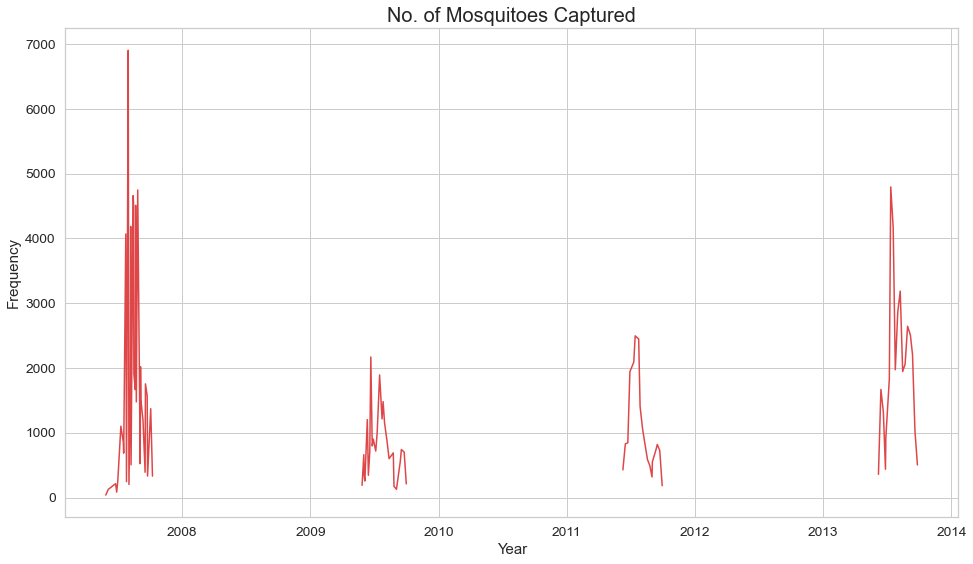

In [ ]:
fig,ax = plt.subplots(figsize=(16,9))

mos_count_2007 = pd.DataFrame(train_weather.groupby('date')['nummosquitos'].sum()).loc['2007']
mos_count_2009 = pd.DataFrame(train_weather.groupby('date')['nummosquitos'].sum()).loc['2009']
mos_count_2011 = pd.DataFrame(train_weather.groupby('date')['nummosquitos'].sum()).loc['2011']
mos_count_2013 = pd.DataFrame(train_weather.groupby('date')['nummosquitos'].sum()).loc['2013']


ax.plot(mos_count_2007,c='#de4648')
ax.plot(mos_count_2009,c='#de4648')
ax.plot(mos_count_2011,c='#de4648')
ax.plot(mos_count_2013,c='#de4648')



ax.set_ylabel('Frequency',size=15)
ax.set_xlabel('Year',size=15)


plt.title('No. of Mosquitoes Captured',size=20);

Interpretation: The graph shows the timeline of the number of mosquitoes captured in the year 2007, 2009, 2011 and 2013. They all exhibit the same trend peaking in the middle of the year in July and August. As can be seen, 2007 had the biggest number of mosquitoes captured. The numbers went down in 2009 and 2011 but picked up again in 2013.

### 2. Number of observations where the virus was found by month

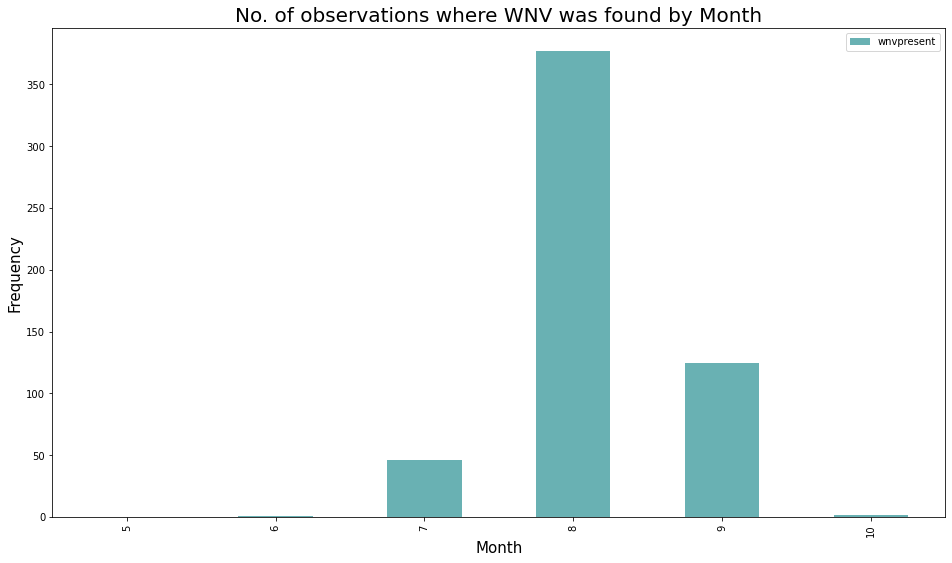

In [ ]:
ax = pd.DataFrame(train_weather.groupby([train_weather['month']]).sum()['wnvpresent']).plot(kind='bar', figsize=(16,9),color='#69b1b3')
ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_title('No. of observations where WNV was found by Month', fontsize=20);

Interpretation: The figure above shows the number of observations (rows/batches) where WNV was detected sorted by months for year 2007,2009,2011,2013 combined. As clearly shown, the cycle seems to start in July and peaking in August (8) with over 350 observations found in year 2007,2009,2011 and 2013 combined before dropping in Autumn.

### 3. Number of observations where the virus was found by week

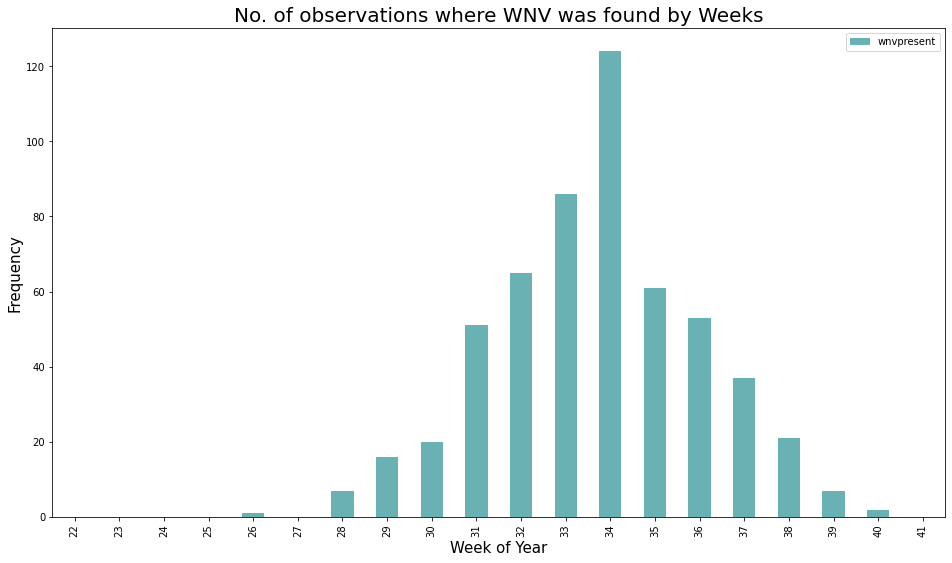

In [ ]:
ax = pd.DataFrame(train_weather.groupby([train_weather['weekofyear']]).sum()['wnvpresent']).plot(kind='bar',color='#69b1b3', figsize=(16,9))
ax.set_xlabel('Week of Year', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_title('No. of observations where WNV was found by Weeks', fontsize=20);

Interpretation: The graph above is a further breakdown of the graph earlier. This graph here makes it easier to see that the number of observations (or batches) for mosquitoes with WNV started increasing rapidly from week 30 onwards until its peak in week 34. Week 35 shows a dramatic drop in the number of observations where WNV were detected and gradually fell from there.

### 4. Number of mosquitoes captured in year and month

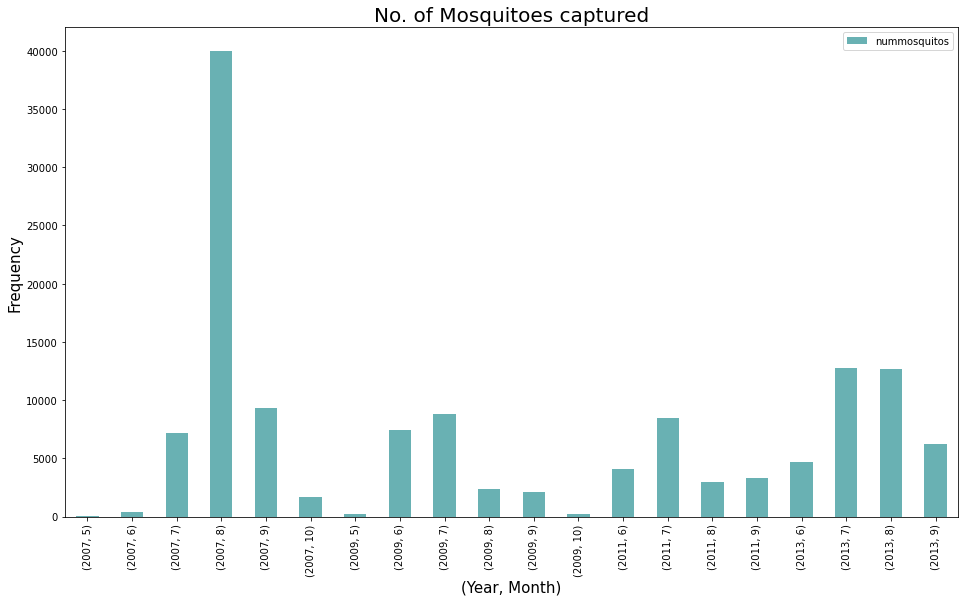

In [ ]:
ax = pd.DataFrame(train.groupby([train['year'], train['month']]).sum()['nummosquitos']).plot(kind='bar', figsize=(16,9),color='#69b1b3')
ax.set_xlabel('(Year, Month)', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_title('No. of Mosquitoes captured', fontsize=20);

Interpretation: The graph here shows a similar cycles for the number of mosquitoes captured in 2007,2009,2011 and 2013. They all exhibited the very similar cycle. However, 2007 showed a slightly different trend than the other years with the peak in August at 40000 which is far above the other years' numbers. The mosquito count from 2009, 2011 and 2013 all had their higest count in July.

### 5. West Nile Virus presence by mosquito species

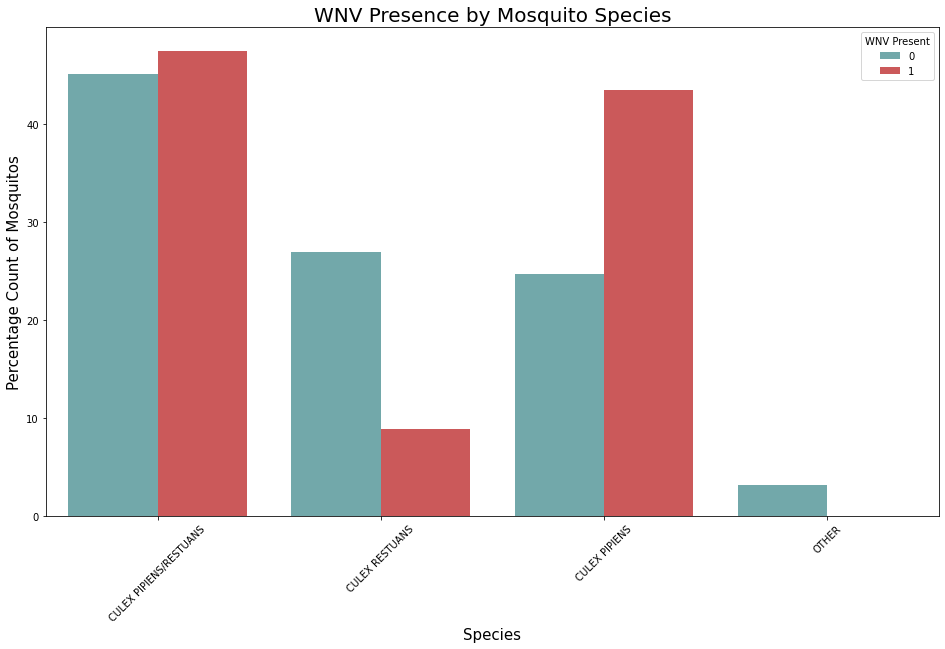

In [ ]:
plt.figure(figsize = (16,9))
species_counts = (train.groupby(['wnvpresent'])['species']
                  .value_counts(normalize=True)
                  .rename('percentage count of mosquitos')
                  .mul(100)
                  .reset_index()
                  .sort_values('species'))
p = sns.barplot(x="species", y="percentage count of mosquitos", 
                hue="wnvpresent", data=species_counts, palette=['#69b1b3','#de4648'],
                order = train['species'].value_counts().index)

_ = plt.setp(p.get_xticklabels(), rotation=45)
plt.legend(title='WNV Present',loc='upper right')
p.set_ylabel('Percentage Count of Mosquitos', fontsize=15)
p.set_xlabel('Species', fontsize=15)
p.set_title('WNV Presence by Mosquito Species', fontsize=20);

#color=['#69b1b3','#76c474','#ebdf6a','#e27071','#de4648','#8D6A9F','#8CBCB9']

Interpretation: The bar chart above shows that West Nile Virus was detected in only 2 mosquito species: CULEX PIPIENS and CULEX RESTUANS. An observation (batch) is more likely to contain WNV if they contain CULEX PIPIENS. In fact, over 40% of the observations that contain CULEX PIPIENS contains WNV.

### 6. West Nile Virus by Mosquito species VS. Spray area

In [ ]:
def plotHeatMap(data, a_cm,ax):
    if(len(data) > 0):
        X = data[['longitude', 'latitude']].values
        kd = KernelDensity(bandwidth=0.02)
        kd.fit(X)
        xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
        gridpoints = np.array([xv.ravel(),yv.ravel()]).T
        zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
        ax.imshow(zv, 
                   origin='lower', 
                   cmap=a_cm, 
                   extent=lon_lat_box, 
                   aspect=aspect)

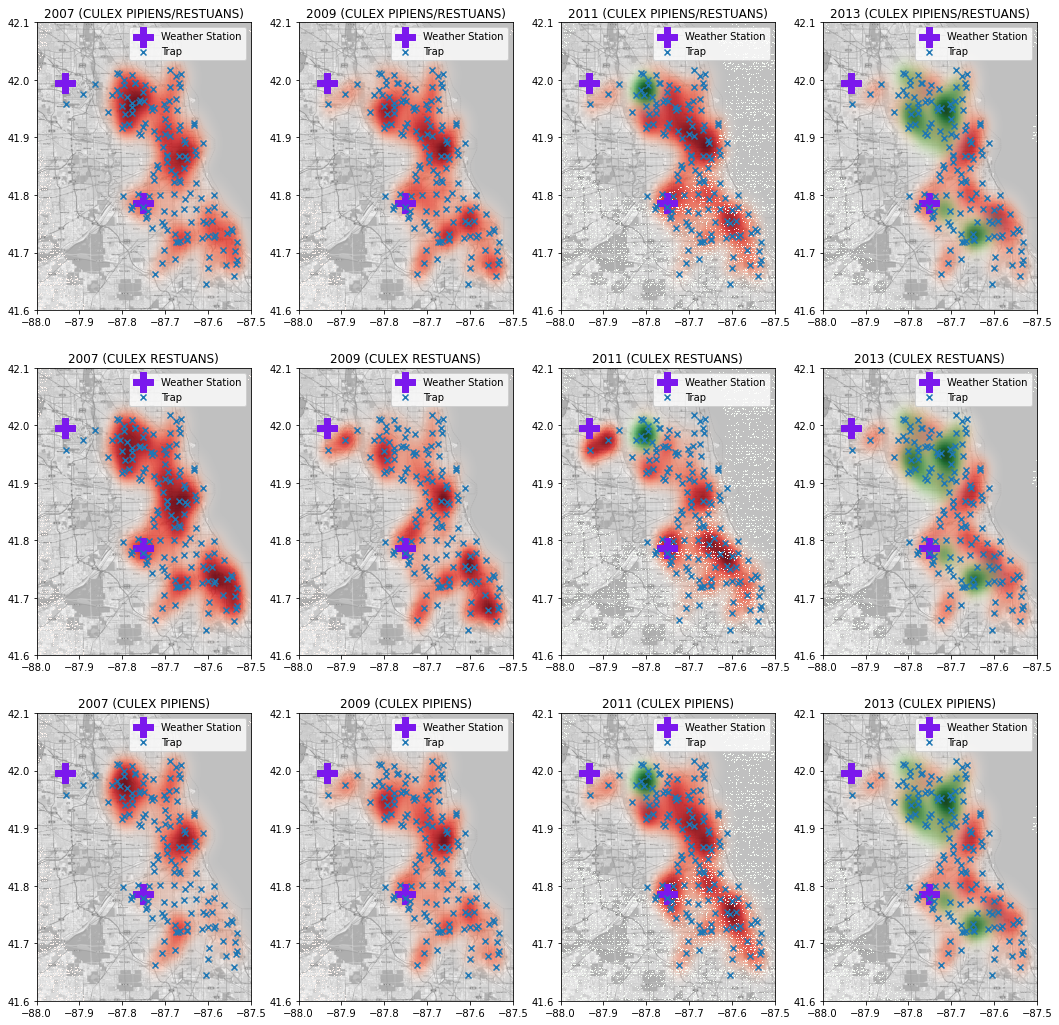

In [ ]:
# Species VS spray

# Import map data
mapdata = np.loadtxt('datasets/mapdata_copyright_openstreetmap_contributors.txt')

alpha_wnv = plt.cm.Reds
alpha_wnv._init()
alpha_wnv._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_wnv.N) / 10 - 1)[::-1]
alpha_sp = plt.cm.Greens
alpha_sp._init()
alpha_sp._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_wnv.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

all_species = ['CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS']

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18,6*(len(all_species))))
counter = 0
for sp_name in range(len(all_species)):
    for year, subplot in zip([2007, 2009, 2011, 2013], [1,2,3,4]):
        #plt.figure(figsize=(18,6*(len(all_species))))
        current_plot = axes.ravel()[counter]
        spray_date = spray[(spray['date'].apply(lambda x: x.year) == year)]
        species_date = train[(train['species'] == all_species[sp_name])
                          & (train['date'].apply(lambda x: x.year) == year)]
        species_date = species_date.groupby(['date', 'trap', 'longitude', 'latitude', 'species']).max()['wnvpresent'].reset_index()
        if(len(species_date) <= 0):
            continue
        #plt.subplot(6, 2, subplot)
        current_plot.set_title(str(year) + " (" + train['species'].unique()[sp_name] + ")")
        current_plot.imshow(mapdata, 
                   cmap=plt.get_cmap('gray'), 
                   extent=lon_lat_box, 
                   aspect=aspect)
        plotHeatMap(species_date, alpha_wnv, current_plot)
        plotHeatMap(spray_date, alpha_sp, current_plot)
        current_plot.scatter(x = [-87.933, -87.752], y = [41.995, 41.786], marker='P', s=400, c = '#7b18ed', label = 'Weather Station')
        #axes[counter].tight_layout()
        locations = train[['longitude', 'latitude']].drop_duplicates().values
        current_plot.scatter(locations[:,0], locations[:,1], marker='x', label = 'Trap')
        current_plot.legend()
        counter += 1

Interpretation: The heatmaps above help us visualize the trap location (x mark), weather station location (+ mark), the presence of each mosquito species with the virus (red) and the spray area (green) in the odd years between 2007-2013. We can clearly see that the mosquito repellent spray was used only in 2011 and 2013. However, there are no clear patterns between mosquito species and locations.

### 7. Areas with West Nile Virus

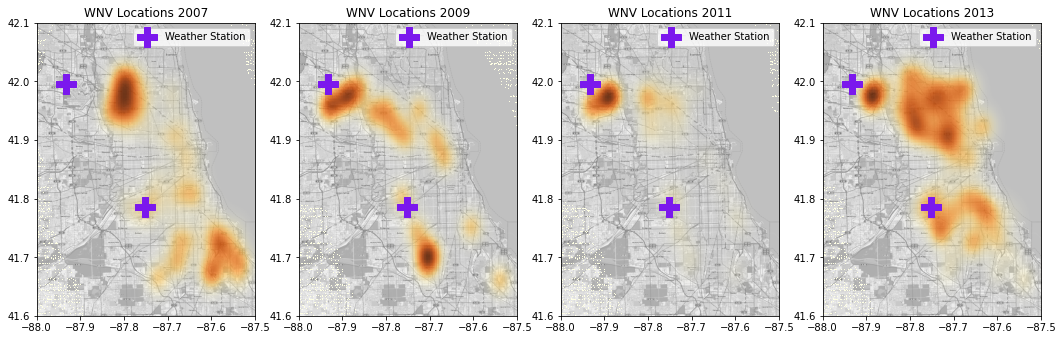

In [ ]:
# Areas with WNV

# Set style
alpha_wnv = plt.cm.YlOrBr
alpha_wnv._init()
alpha_wnv._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_wnv.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

all_species = train['species'].unique()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,6*(len(all_species))))
counter = 0

for year, subplot in zip([2007, 2009, 2011, 2013], [1,2,3,4]):
    #plt.figure(figsize=(18,6*(len(all_species))))
    
    current_plot = axes.ravel()[counter]
    
    spray_date = spray[(spray['date'].apply(lambda x: x.year) == year)]
    wnv_date = train[(train['wnvpresent'] == 1)
                      & (train['date'].apply(lambda x: x.year) == year)]
    wnv_date = wnv_date.groupby(['date', 'trap', 'longitude', 'latitude', 'species']).max()['wnvpresent'].reset_index()
    if(len(species_date) <= 0):
        continue
    #current_plot.subplot(len(all_species), 4, subplot)
    current_plot.set_title(f'WNV Locations {str(year)}')
    current_plot.imshow(mapdata, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)
    plotHeatMap(wnv_date, alpha_wnv,current_plot)
    current_plot.scatter(x = [-87.933, -87.752], y = [41.995, 41.786], marker='P', s=400, c = '#7b18ed', label = 'Weather Station')

    #plt.tight_layout()
    #locations = train[['longitude', 'latitude']].drop_duplicates().values
    #current_plot.scatter(locations[:,0], locations[:,1], marker='x', label = 'Trap')
    current_plot.legend()
    counter += 1

Interpretation: The diagram above shows the concentration of areas where WNV have been found in the year 2007, 2009, 2011 and 2013. With the exception of 2011, it looks like WNV was spreading with increasing concentration in the north of Chicago. The areas near the northern weather station are consistently infested with WNV across the four year data.

### 8. West Nile Virus VS. Spray area

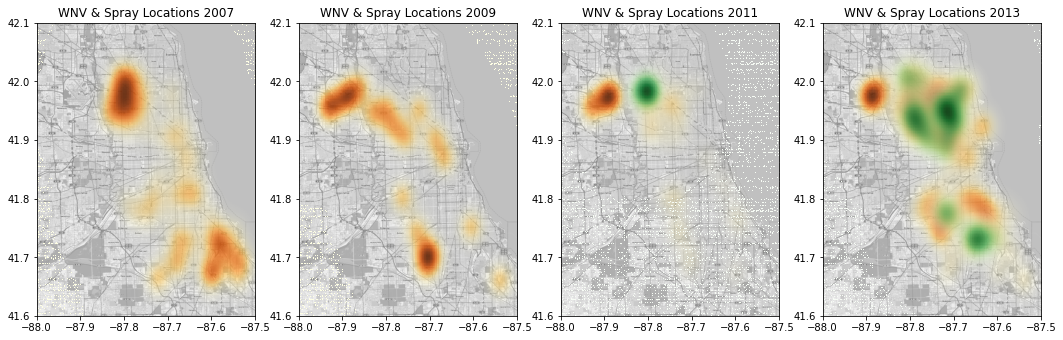

In [ ]:
# Virus VS spray

# Set style
alpha_wnv = plt.cm.YlOrBr
alpha_wnv._init()
alpha_wnv._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_wnv.N) / 10 - 1)[::-1]
alpha_sp = plt.cm.Greens
alpha_sp._init()
alpha_sp._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_wnv.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

all_species = train['species'].unique()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,6*(len(all_species))))
counter = 0

for year, subplot in zip([2007, 2009, 2011, 2013], [1,2,3,4]):
    #plt.figure(figsize=(18,6*(len(all_species))))
    
    current_plot = axes.ravel()[counter]
    
    spray_date = spray[(spray['date'].apply(lambda x: x.year) == year)]
    wnv_date = train[(train['wnvpresent'] == 1)
                      & (train['date'].apply(lambda x: x.year) == year)]
    wnv_date = wnv_date.groupby(['date', 'trap', 'longitude', 'latitude', 'species']).max()['wnvpresent'].reset_index()
    if(len(species_date) <= 0):
        continue
    #current_plot.subplot(len(all_species), 4, subplot)
    current_plot.set_title(f'WNV & Spray Locations {str(year)}')
    current_plot.imshow(mapdata, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)
    plotHeatMap(wnv_date, alpha_wnv,current_plot)
    plotHeatMap(spray_date, alpha_sp,current_plot)
    #current_plot.scatter(x = [-87.933, -87.752], y = [41.995, 41.786], marker='P', s=400, c = '#7b18ed', label = 'Weather Station')

    #plt.tight_layout()
    #locations = train[['longitude', 'latitude']].drop_duplicates().values
    #current_plot.scatter(locations[:,0], locations[:,1], marker='x', label = 'Trap')
    #current_plot.legend()
    counter += 1

Interpretation: The areas shown in yellow show the locations where WNV was detected and the areas in green are where the mosquito spraying took place. The spraying data was only available for 2011 and 2013. The 2011 plot illustrates that the sprays were targeted in areas with low WNV presence. This likely led to a misallocation of resources. The 2013 plot shows that there is a wider coverage of the spraying that took place. It can be clearly seen that the locations for where these sprays were deployed in 2013 were much better, although the areas near the northern weather station where there's consistently high concentration of WNV were not targeted.

### 9. Number of virus-carrying mosquito species by trap

Text(0, 0.5, 'Number of mosquitos')

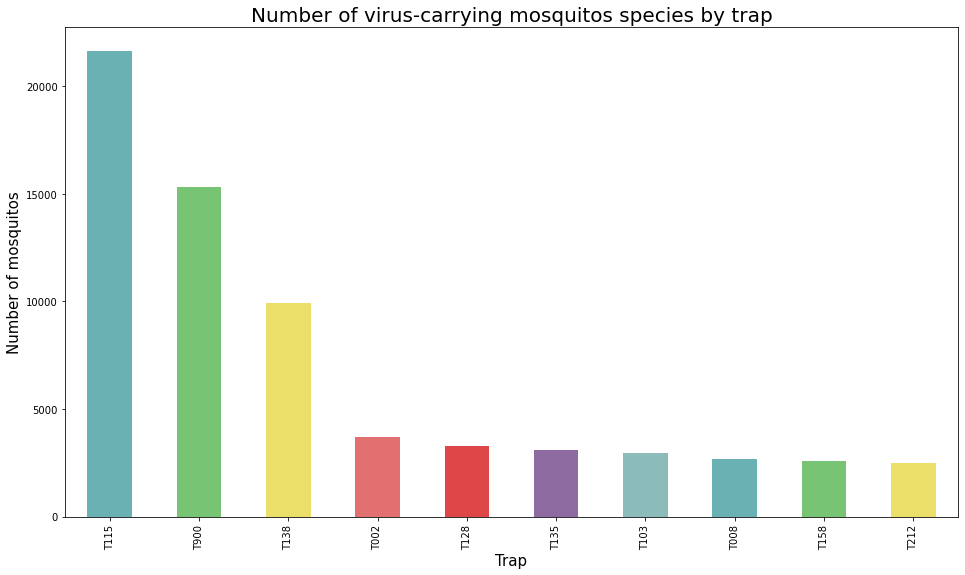

In [ ]:
plt.figure(figsize=(16,9))
train[train['species'].isin(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS'])].groupby('trap')['nummosquitos'].sum().sort_values(ascending = False)[:10].plot(kind = 'bar',color=['#69b1b3','#76c474','#ebdf6a','#e27071','#de4648','#8D6A9F','#8CBCB9'])
plt.title('Number of virus-carrying mosquitos species by trap',size=20)
plt.xlabel('Trap',size=15)
plt.ylabel('Number of mosquitos',size=15)

Interpretation: The bar chart above shows how well does each trap catch the virus-carrying mosquitoes. T115 had the highest number of virus-carrying mosquitoes, followed by T900 and T138.

### 10. Relationship between West Nile Virus and Temperature/Precipitation at station 1 and station 2

D:\Users\Boss\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Users\Boss\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


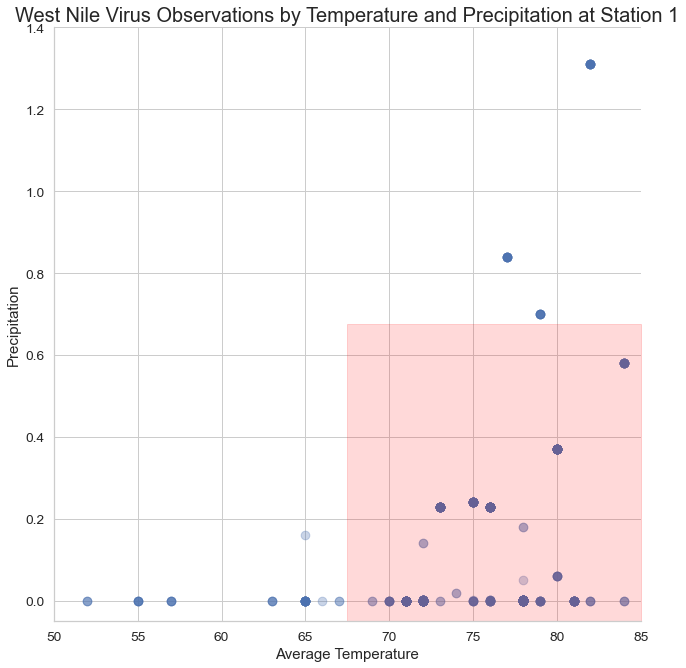

In [ ]:
# Visualize the relationship between West Nile Virus and Temperature/Precipitation 
temp_precip_wnv_df = train_weather[['tavg_station1', 'preciptotal_station1', 'wnvpresent']]

sns.set(font_scale=1.25, style='whitegrid')
sns.lmplot('tavg_station1','preciptotal_station1', data = temp_precip_wnv_df[temp_precip_wnv_df['wnvpresent']==1], fit_reg = False, size = 9, scatter_kws = {'s':75,'alpha':0.3})

# Labels
plt.title("West Nile Virus Observations by Temperature and Precipitation at Station 1",size=20)
plt.xlim(50, 85)
plt.ylim(-0.05, 1.4)
plt.xlabel("Average Temperature",size=15)
plt.ylabel("Precipitation",size=15)

# Color lower right quadrant 
plt.fill_between([(85+50)/2, 85], -0.05, (1.4 + (-.05))/2, color='red', alpha=0.15)

D:\Users\Boss\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Users\Boss\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


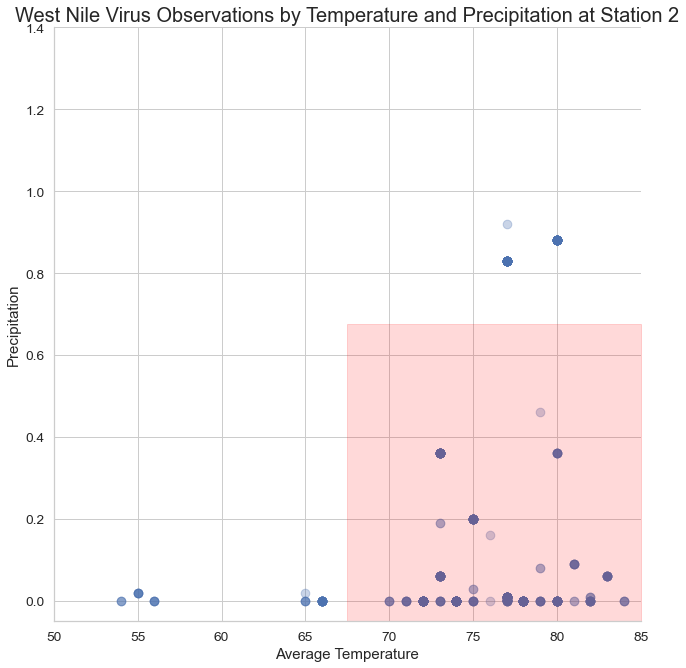

In [ ]:
# Visualize the relationship between West Nile Virus and Temperature/Precipitation 
temp_precip_wnv_df = train_weather[['tavg_station2', 'preciptotal_station2', 'wnvpresent']]

sns.set(font_scale=1.25, style='whitegrid')
sns.lmplot('tavg_station2','preciptotal_station2', data = temp_precip_wnv_df[temp_precip_wnv_df['wnvpresent']==1], fit_reg = False, size = 9, scatter_kws = {'s':75,'alpha':0.3})

# Labels
plt.title("West Nile Virus Observations by Temperature and Precipitation at Station 2",size=20)
plt.xlim(50, 85)
plt.ylim(-0.05, 1.4)
plt.xlabel("Average Temperature",size=15)
plt.ylabel("Precipitation",size=15)

# Color lower right quadrant 
plt.fill_between([(85+50)/2, 85], -0.05, (1.4-.05)/2, color='red', alpha=0.15)

plt.show()

Interpretation: The two diagrams above show the weather condition and the presence of WNV. It can be seen here that WNV were detected more often in the condition where the tempture is warmer and less humid.

# Modeling

### Baseline

In [ ]:
train_weather['wnvpresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnvpresent, dtype: float64

Since our original data is severely unbalanced with around 95% beloning to the Negative Class (0 - No Virus) and only 5% belonging to the Positive class (1 - Virus Present), using accuracy as our model evaluation metrics would be nonsensical since a model that predicts the majority class all the time would score extremely high accuracy. In this case, we are more concerned about getting the correct Positive class prediction and, thus, will be using ROCAUC as our evaluation metric.

Our baseline score is an ROCAUC score of 0.5, meaning that the baseline model the model has no class separation capacity whatsoever.

In [ ]:
#Define X and y
y = train_weather['wnvpresent']
X = train_weather.drop(columns=['wnvpresent','date','yearmonth']) # don't drop nummosquitos

In [ ]:
#train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42, test_size=0.1)

In [ ]:
X_train.shape

(9455, 164)

In [ ]:
y_train.shape

(9455,)

In [ ]:
X_val.shape

(1051, 164)

In [ ]:
y_val.shape

(1051,)

In [ ]:
y_train.value_counts(normalize=True)

0    0.947541
1    0.052459
Name: wnvpresent, dtype: float64

## Logistic Regression

Since Logistic Regression requires the data to be in the same magnitude to work effectively we will, first, be applying standard scaler to the features. As the data is severely unbalanced with around 95% belonging to the Negative (0) class, we will be using SMOTE to resample our data so that our dataset is more balanced. Failure to perform the previous technique will result in the model being more likely to be biased towards predicting the majority class. 

In [ ]:
pipe_lr = Pipeline([('sc', StandardScaler()), 
                    ('sm', SMOTE(random_state = 42)), #imbalanced sampling
                    ('lr', LogisticRegression(random_state = 42, solver='liblinear'))])

In [ ]:
pipe_lr_params = {'lr__penalty': ['l1','l2'],
                  'lr__C': [.1,1,10],
                 'sm__k_neighbors':[1,3,5],}

In [ ]:
gs_lr = GridSearchCV(pipe_lr,
                     param_grid = pipe_lr_params,
                     cv=5, 
                     n_jobs= -1,
                     scoring='roc_auc',
                     verbose=10)

In [ ]:
gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('sm', SMOTE(random_state=42)),
                                       ('lr',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.1, 1, 10], 'lr__penalty': ['l1', 'l2'],
                         'sm__k_neighbors': [1, 3, 5]},
             scoring='roc_auc', verbose=10)

In [ ]:
lr_pred = gs_lr.predict(X_val)

In [ ]:
lr_pred_proba = gs_lr.predict_proba(X_val)[:,1]

In [ ]:
print('Best parameters: ', gs_lr.best_params_)
print('Best estimator\'s CV AUC score: ', gs_lr.best_score_) 
print('Training AUC score:', gs_lr.score(X_train, y_train))
print('Validation AUC score:', gs_lr.score(X_val, y_val))

Best parameters:  {'lr__C': 0.1, 'lr__penalty': 'l1', 'sm__k_neighbors': 1}
Best estimator's CV AUC score:  0.8366820540744848
Training AUC score: 0.8875596804798922
Validation AUC score: 0.8303851770719242


In [ ]:
sorted(list(zip(X_train.columns,np.exp(gs_lr.best_estimator_.steps[2][1].coef_[0]))),key=lambda row : row[1],reverse=True)

[('tavg_station1', 159.9547895328319),
 ('nummosquitos', 3.1255977032888183),
 ('month', 2.4331594013569298),
 ('weekofyear', 2.22208716549218),
 ('dewpoint_station1', 2.089267793790067),
 ('avgspeed_station2', 1.7029419845848275),
 ('year', 1.692812773091685),
 ('resultspeed_station1', 1.4921033186382702),
 ('tmax_station1', 1.487975442489102),
 ('resultdir_station1', 1.3359951093631666),
 ('preciptotal_station2', 1.2238870580504606),
 ('species_CULEX PIPIENS', 1.1948820689802324),
 ('trap_T073', 1.1710186610558164),
 ('trap_T221', 1.156245911726591),
 ('trap_T082', 1.1486087852233626),
 ('trap_T096', 1.1457128333474835),
 ('trap_T090', 1.136409976727514),
 ('trap_T028', 1.1257159168394344),
 ('trap_T160', 1.1248732238478725),
 ('trap_T095', 1.1190593104921884),
 ('trap_T081', 1.1143890815113664),
 ('trap_T015', 1.1120160279096691),
 ('trap_T225', 1.1085779694688902),
 ('trap_T107', 1.1083188936035535),
 ('trap_T230', 1.108001901182753),
 ('trap_T094', 1.1038848803074832),
 ('trap_T00

In [ ]:
lr_coef = pd.DataFrame(sorted(list(zip(X_train.columns,np.exp(gs_lr.best_estimator_.steps[2][1].coef_[0]))),key=lambda row : row[1],reverse=True),columns=['Feature','Exp(coef)'])
lr_coef.head(10)

,Feature,Exp(coef)
0,tavg_station1,159.954790
1,nummosquitos,3.125598
2,month,2.433159
3,weekofyear,2.222087
4,dewpoint_station1,2.089268
5,avgspeed_station2,1.702942
6,year,1.692813
7,resultspeed_station1,1.492103
8,tmax_station1,1.487975
9,resultdir_station1,1.335995


Interpretation: Some of the most important factors affecting the presence of WNV includes the average temperture, the number of mosquitoes, month and week. In fact, an increase of one unit of the average temperature (at station 1) results in the a given trap being 160 times more likely to contain mosquitoes with WNV.

#### LogisticRegression Model Evaluation

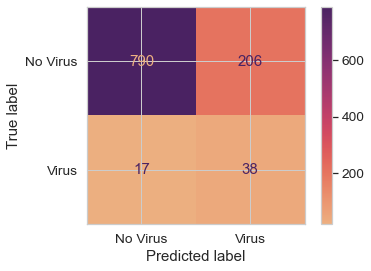

In [ ]:
plot_confusion_matrix(gs_lr,X_val,y_val,cmap='flare',display_labels=['No Virus','Virus']);

|                | ROCAUC Score |
|----------------|---------------|
| Training       | 0.888         |
| CV             | 0.837        |
| Validation     | 0.830         |
| Testing/Kaggle | 0.756        |

The Logistic Regression model built has a relatively good ROCAUC score on unseen Testing set (Kaggle) at 0.756 which is slightly lower than the cross validation set. Compared to the ROCAUC score of on the training set (0.888), it does seem that this model suffers somewhat from overfitting with large variance and relatively low bias. The confusion matrix above shows that the model correctly classed that samples have 'No Virus' 790 times. However, the model incorrectly classed 'No Virus' as 'Virus' 206 times which is quite high. We will be comparing these numbers with the other models.

## Random Forest

Unlike Logistic Regression, Decision Tree based ensemble algorithms do not require the data to be in the same magnitude of measurement so scaling is not necessary. We will be performing SMOTE to deal with data imbalance.

In [ ]:
pipe_rf = Pipeline([('sm', SMOTE(random_state = 42)), 
                    ('rf', RandomForestClassifier(random_state = 42))])

In [ ]:
pipe_rf_params = {
    'sm__k_neighbors':[1,3,5],
    'rf__n_estimators': [50,250,500],
    'rf__max_depth': [1,3,5], 
    'rf__min_samples_split': [2,4]}

In [ ]:
gs_rf = GridSearchCV(pipe_rf,
                     param_grid=pipe_rf_params,
                     cv=5, 
                     n_jobs=-1,
                     scoring='roc_auc',
                     verbose=10)

In [ ]:
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [1, 3, 5],
                         'rf__min_samples_split': [2, 4],
                         'rf__n_estimators': [50, 250, 500],
                         'sm__k_neighbors': [1, 3, 5]},
             scoring='roc_auc', verbose=10)

In [ ]:
rf_pred = gs_rf.predict(X_val)

In [ ]:
rf_pred_proba = gs_rf.predict_proba(X_val)[:,1]

In [ ]:
print('Best parameters: ', gs_rf.best_params_)
print('Best CV AUC score: ', gs_rf.best_score_)
print('Training AUC score:', gs_rf.score(X_train, y_train))
print('Validation AUC score:', gs_rf.score(X_val, y_val))

Best parameters:  {'rf__max_depth': 5, 'rf__min_samples_split': 4, 'rf__n_estimators': 50, 'sm__k_neighbors': 1}
Best CV AUC score:  0.8561336171069996
Training AUC score: 0.8842653269914197
Validation AUC score: 0.8455366922234392


In [ ]:
#rank features importance
rf_features_importance = gs_rf.best_estimator_.steps[1][1].feature_importances_
rf_features = pd.DataFrame({'features': X_train.columns, 
                            'features_importance': rf_features_importance}).sort_values('features_importance', ascending=False)
rf_features.iloc[:20]

,features,features_importance
2,nummosquitos,0.156745
25,daytime,0.135297
5,weekofyear,0.124281
26,species_CULEX PIPIENS,0.061725
4,month,0.042604
28,species_CULEX RESTUANS,0.030729
22,resultspeed_station2,0.030511
11,wetbulb_station1,0.029905
13,resultspeed_station1,0.028289
8,tavg_station1,0.027680


#### Random Forest Model Evaluation

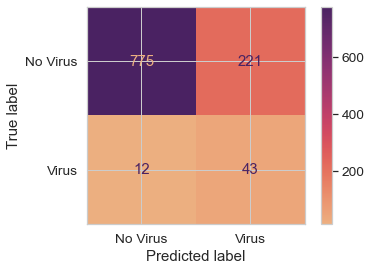

In [ ]:
plot_confusion_matrix(gs_rf,X_val,y_val,cmap='flare',display_labels=['No Virus','Virus']);

|                | ROC AUC Score |
|----------------|---------------|
| Training       | 0.884         |
| CV             | 0.856         |
| Validation     | 0.846         |
| Testing/Kaggle | 0.709        |

The Random Forest model has the ROCAUC score on unseen Testing set (Kaggle) at 0.709 which is worse than the previous Logistic Regression Model (0.756). Compared to the ROCAUC score of on the training set (0.884), it seems that this model also suffers more from overfitting than the Logistic Regression model. The confusion matrix above shows that the model correctly classed that samples have 'No Virus' 775 times. However, the model incorrectly classed 'No Virus' as 'Virus' 221 times which is quite high. 

## Extra Trees

Since our Random Forest model exhibit overfitting, we will be seeing it Extra Tree performs better as the random elements in the Extra Trees algorithm can usually help reduce variance at the cost of increasing bias.

In [ ]:
pipe_et = Pipeline([('sm', SMOTE(random_state = 42)), 
                    ('et', ExtraTreesClassifier(random_state = 42))])

In [ ]:
pipe_et_params = {'et__n_estimators': [100, 200],
                  'et__max_depth': [2, 4],
                  'et__min_samples_leaf': [3, 5, 7],
                  'et__class_weight' : ['balanced', 'balanced_subsample'],
                  'sm__k_neighbors':[1,3,5]
            }

In [ ]:
gs_et = GridSearchCV(pipe_et,
                     param_grid=pipe_et_params,
                     cv=5, 
                     n_jobs=-1,
                     scoring='roc_auc',
                     verbose=1)

In [ ]:
gs_et.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('et',
                                        ExtraTreesClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'et__class_weight': ['balanced', 'balanced_subsample'],
                         'et__max_depth': [2, 4],
                         'et__min_samples_leaf': [3, 5, 7],
                         'et__n_estimators': [100, 200],
                         'sm__k_neighbors': [1, 3, 5]},
             scoring='roc_auc', verbose=1)

In [ ]:
et_pred = gs_et.predict(X_val)

In [ ]:
et_pred_proba = gs_et.predict_proba(X_val)[:,1]

In [ ]:
print('Best parameters: ', gs_et.best_params_)
print('Best CV AUC score: ', gs_et.best_score_)
print('Training AUC score:', gs_et.score(X_train, y_train))
print('Validation AUC score:', gs_et.score(X_val, y_val))

Best parameters:  {'et__class_weight': 'balanced', 'et__max_depth': 4, 'et__min_samples_leaf': 3, 'et__n_estimators': 200, 'sm__k_neighbors': 1}
Best CV AUC score:  0.8392705064599694
Training AUC score: 0.8611856116934133
Validation AUC score: 0.8251277838627236


#### ExtraTree Model Evaluation

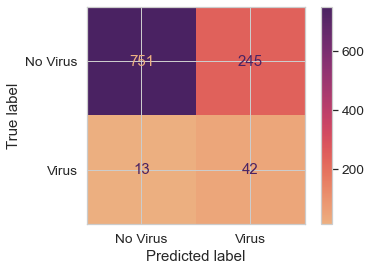

In [ ]:
plot_confusion_matrix(gs_et,X_val,y_val,cmap='flare',display_labels=['No Virus','Virus']);

|                | ROC AUC Score |
|----------------|---------------|
| Training       | 0.861         |
| CV             | 0.839         |
| Validation     | 0.825         |
| Testing/Kaggle | 0.720        |

Extra Tree's ROCAUC scores for training and cross validation set are lower than Random Forest. However, the variance has gone down slightly as expected. The ROCAUC score also increased on the unseen Testing/Kaggle set suggesting a bit more generalised model than Random Forest. The confusion matrix paints a similar picture where there are relatively high number of False Positive (incorrectly predicting Virus) at 245.

## XGBoost

In [ ]:
pipe_xgb = Pipeline([('sm', SMOTE(random_state = 42)), 
                     ('xgb', XGBClassifier(random_state = 42))])

In [ ]:
pipe_xgb_params = {
    'xgb__eval_metric' : ['auc'],
    'xgb__subsample' : [0.5],
    'xgb__colsample_bytree' : [0.5], 
    'xgb__learning_rate' : [.001, .01, .1], 
    'xgb__n_estimators' : [100],
    'xgb__reg_alpha' : [0.01],
    'xgb__gamma' : [0.1],
    'xgb__objective' : ['binary:logistic'],
    'sm__k_neighbors':[1,3,5]
}

In [ ]:
gs_xgb = GridSearchCV(pipe_xgb,
                      param_grid=pipe_xgb_params,
                      cv=5, 
                      n_jobs=-1,
                      scoring='roc_auc',
                      verbose=1)

In [ ]:
gs_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


D:\Users\Boss\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                

In [ ]:
xgb_pred = gs_xgb.predict(X_val)

In [ ]:
xgb_pred_proba = gs_xgb.predict_proba(X_val)[:,1]

In [ ]:
print('Best parameters: ', gs_xgb.best_params_)
print('Best CV AUC score: ', gs_xgb.best_score_)
print('Training AUC score:', gs_xgb.score(X_train, y_train))
print('Validation AUC score:', gs_xgb.score(X_val, y_val))

Best parameters:  {'sm__k_neighbors': 5, 'xgb__colsample_bytree': 0.5, 'xgb__eval_metric': 'auc', 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.1, 'xgb__n_estimators': 100, 'xgb__objective': 'binary:logistic', 'xgb__reg_alpha': 0.01, 'xgb__subsample': 0.5}
Best CV AUC score:  0.8665738089119843
Training AUC score: 0.930313475546306
Validation AUC score: 0.8458105147864184


#### XGB Model Evaluation

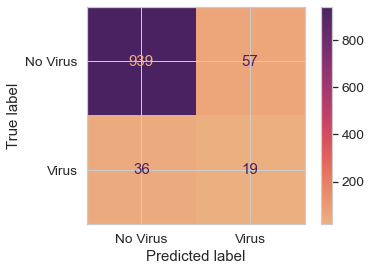

In [ ]:
plot_confusion_matrix(gs_xgb,X_val,y_val,cmap='flare',display_labels=['No Virus','Virus']);

|                | ROC AUC Score |
|----------------|---------------|
| Training       | 0.930         |
| CV             | 0.867         |
| Validation     | 0.846         |
| Testing/Kaggle | 0.695         |

XGBoost model scored the best in the training set at 0.93 when compared to the other models. However, the ROCAUC on the cross validation is much lower suggesting high variance and low bias. When the model is scored for the unseen Testing/Kaggle set, it performed the worst at 0.695 due to the model being overfitted. The confusion matrix also shows a different picture to the confusion matrices of the three previous models. XGBoost model seems predict a lot more Negative class (No Virus) resulting in a much lower number of False Positives.

## Model Evaluation/Comparison

In [ ]:
l_perf = (confusion_matrix(y_val, gs_lr.predict(X_val))).ravel()
rf_perf = (confusion_matrix(y_val, gs_rf.predict(X_val))).ravel()
et_perf = (confusion_matrix(y_val, gs_et.predict(X_val))).ravel()
xgb_perf = (confusion_matrix(y_val, gs_xgb.predict(X_val))).ravel()
#tn, fp, fn, tp
l_perf = [l_perf[3],l_perf[1],l_perf[0],l_perf[2]]
rf_perf = [rf_perf[3],rf_perf[1],rf_perf[0],rf_perf[2]]
et_perf = [et_perf[3],et_perf[1],et_perf[0],et_perf[2]]
xgb_perf = [xgb_perf[3],xgb_perf[1],xgb_perf[0],xgb_perf[2]]

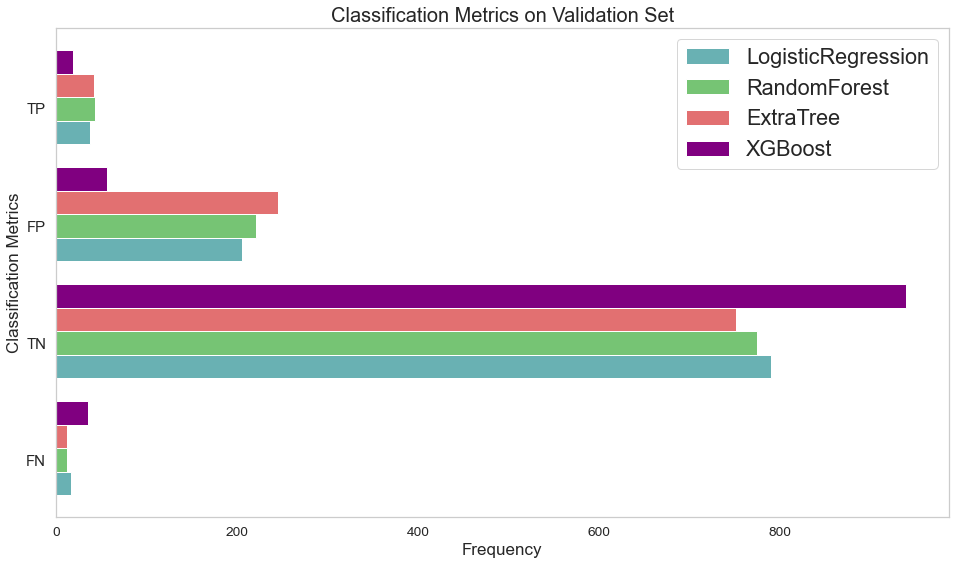

In [ ]:
ind = np.arange(4)  # the x locations for the groups
width = 0.20       # the width of the bars

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
rects1 = ax.barh(ind, l_perf[::-1], width, color='#69b1b3')
rects2 = ax.barh(ind+width,rf_perf[::-1], width, color='#76c474')
rects3 = ax.barh(ind+2*width, et_perf[::-1], width, color='#e27071')
rects4 = ax.barh(ind+3*width, xgb_perf[::-1], width, color='purple')

#['#69b1b3','#76c474','#ebdf6a','#e27071','#de4648','#8D6A9F','#8CBCB9']
# add some
ax.set_ylabel('Classification Metrics', size = 17)
ax.set_xlabel('Frequency', size = 17)
ax.set_title('Classification Metrics on Validation Set', size = 20)
ax.set_yticks(ind + width )
ax.set_yticklabels(['TP', 'FP', 'TN', 'FN'][::-1],size=15)
ax.legend( (rects1[0], rects2[0],rects3[0],rects4[0]), ('LogisticRegression', 'RandomForest','ExtraTree','XGBoost'),fontsize = 'x-large')
plt.grid(axis='both',which='both',alpha=0.5)
plt.show()

Interpretation: The bar chart above shows the raw number of TP (Correctly Predicting Virus), FP (Incorrectly Predicting Virus), TN (Correctly Predicting No Virus) and FN (Incorrectly Predicting Virus) by models. Logistic Regression, Random Forest and Extra tree all paint very similar pictures. They predict a higher number of Positive (Virus) class in general leading to a much bigger number of False Positives when compared to XGBoost. However, in our particular case, this may be desirable as we want to ensure that we are capturing the Positive class as much as possible even if may lead to cases of false alarms. This is because we are placing the importance on the positive class. In simple terms, we don't want to predict that an area does not have the virus when it actually does as this could result in the local authorities diverting resouces to other areas leading to this particular area being infested with the virus.

### ROC AUC

In [ ]:
# ROCAUC LogisticRegression
logreg_fpr, logreg_tpr, thresh = roc_curve(y_val, gs_lr.predict_proba(X_val)[:,1])
logreg_auc = auc(logreg_fpr,logreg_tpr)
logreg_auc

0.8303851770719242

In [ ]:
# ROCAUC RandomForestClassifier
rf_fpr, rf_tpr, thresh = roc_curve(y_val, gs_rf.predict_proba(X_val)[:,1])
rf_auc = auc(rf_fpr,rf_tpr)
rf_auc

0.8455366922234392

In [ ]:
# ROCAUC ExtraTree
et_fpr, et_tpr, thresh = roc_curve(y_val, gs_et.predict_proba(X_val)[:,1])
et_auc = auc(et_fpr,et_tpr)
et_auc

0.8251277838627236

In [ ]:
# ROCAUC XGBoost
xgb_fpr, xgb_tpr, thresh = roc_curve(y_val, gs_xgb.predict_proba(X_val)[:,1])
xgb_auc = auc(xgb_fpr,xgb_tpr)
xgb_auc

0.8458105147864184

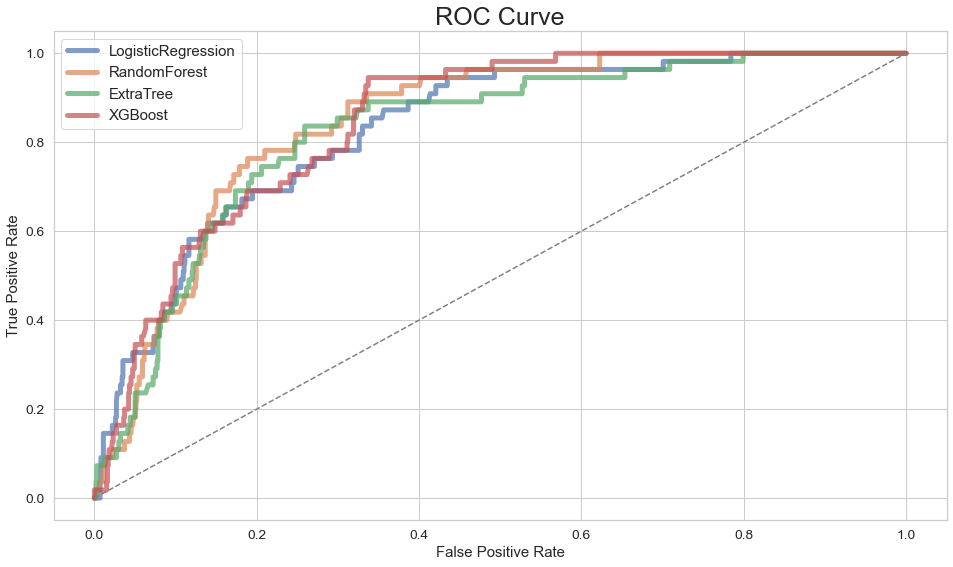

In [ ]:
plt.figure(figsize=(16,9))

plt.plot(logreg_fpr,logreg_tpr,label='LogisticRegression',linewidth=5,alpha=0.7)
plt.plot(rf_fpr,rf_tpr,label='RandomForest',linewidth=5,alpha=0.7)
plt.plot(et_fpr,et_tpr,label='ExtraTree',linewidth=5,alpha=0.7)
plt.plot(xgb_fpr,xgb_tpr,label='XGBoost',linewidth=5,alpha=0.7)


plt.plot([0,1],[0,1],color='gray',linestyle = 'dashed')
plt.xlabel('False Positive Rate',size=15)
plt.ylabel('True Positive Rate',size=15)
plt.legend(fontsize=15)
plt.title('ROC Curve',size=25);

|  ROCAUC Score  |LogisticRegression|RandomForest|ExtraTree      |XGBoost        |
|----------------|---------------| -----------    | ----------   |--------------|
| Training       | 0.888        | 0.884         | 0.861         | 0.930         |
| CV             |0.837         | 0.856         | 0.839         | 0.867         |
| Validation     | 0.830         | 0.846         | 0.825         | 0.846         |
| Testing/Kaggle | 0.756          | 0.709         | 0.720         | 0.695         |

Interpretation: The ROC Curve above illustrates the performances of Logistic Regression, Random Forest, Extra Tree and XGBoost on the unseen validation set (not to be confused with our cross-validation set). The model that scored the highest ROCAUC is XGBoost, followed by Random Forest, Logistic Regression and Extra Tree. However, the differences are very small differing by only around 0.01. However, when it comes to scoring on Kaggle on the testing set, XGBoost performed the worst compared to the other models. This could be attributed to the fact that XGBoost suffers from high variance resulting in bad generalisation. On the testing set, Logistic Regression seems to be more generalised (lower variance). The model scored the best on the testing data with the ROCAUC score of 0.756 and thus we will consider this model to be the most useful for the purpose of this study.

### Using the best model on the Test Dataset

In [ ]:
test_weather.columns

Index(['id', 'date', 'latitude', 'longitude', 'year', 'month', 'weekofyear',
       'yearmonth', 'tmax_station1', 'tmin_station1',
       ...
       'trap_T231', 'trap_T232', 'trap_T233', 'trap_T235', 'trap_T236',
       'trap_T237', 'trap_T238', 'trap_T900', 'trap_T903', 'nummosquitos'],
      dtype='object', length=167)

In [ ]:
X_test = test_weather.drop(columns=['date','yearmonth','id'])

In [ ]:
X_test.shape

(116293, 164)

In [ ]:
#check if there are same columns
set(X_test.columns).symmetric_difference(set(X_train.columns))

set()

In [ ]:
X_test = X_test[X_train.columns]

In [ ]:
#calculate prediction probs
y_pred = gs_lr.predict_proba(X_test)[:,1]

In [ ]:
#save the results
results = pd.DataFrame({'Id': test['id'].values,'WnvPresent': y_pred})
results.head()

,Id,WnvPresent
0,1,0.000342
1,2,0.000058
2,3,0.000178
3,4,0.000003
4,5,0.000003


In [ ]:
#export to csv
results.to_csv('submission.csv',index=False )

## Cost Benefit Analysis

<img src="./images/cba1.PNG">

**Sources**
- [West Nile virus hospitalizations cost nearly $800 million in U.S. since 1999, study shows](https://www.sciencedaily.com/releases/2014/02/140210184713.htm)

- [The drivers of West Nile virus human illness in the Chicago, Illinois, USA area: Fine scale dynamic effects of weather, mosquito infection, social, and biological conditions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7241786/)

- [A comparison of least squares regression and geographically weighted regression modeling of West Nile virus risk based on environmental parameters](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5372833)

In [ ]:
spray

,date,time,latitude,longitude,year,month
0,2011-08-29,2021-04-03 18:56:58,42.391623,-88.089163,2011,08
1,2011-08-29,2021-04-03 18:57:08,42.391348,-88.089163,2011,08
2,2011-08-29,2021-04-03 18:57:18,42.391022,-88.089157,2011,08
3,2011-08-29,2021-04-03 18:57:28,42.390637,-88.089158,2011,08
4,2011-08-29,2021-04-03 18:57:38,42.390410,-88.088858,2011,08
...,...,...,...,...,...,...
14830,2013-09-05,2021-04-03 20:34:11,42.006587,-87.812355,2013,09
14831,2013-09-05,2021-04-03 20:35:01,42.006192,-87.816015,2013,09
14832,2013-09-05,2021-04-03 20:35:21,42.006022,-87.817392,2013,09
14833,2013-09-05,2021-04-03 20:35:31,42.005453,-87.817423,2013,09


#### Number of spray VS. number of mosquitos

We will first look at the relationship between number of spray used and number of mosquitos. The goal is to see the effectiveness of the spray in terms of reducing the number of mosquitos. 

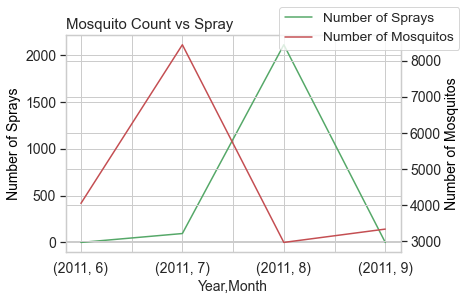

In [ ]:
#2011
spray['year'] = [str(i)[:4] for i in spray['date']]
spray['month'] = [str(i)[5:7] for i in spray['date']]
spray2011 = list(spray[spray['year'] == '2011'].groupby(by=['year', 'month']).count()['date'].values)
spray2011.insert(0,0)
spray2011.insert(3,0)
df = pd.DataFrame({"Year,Month": list(train[train['year'] == 2011].groupby(by=['year', 'month']).sum()['nummosquitos'].index),
                   "Number of Sprays": spray2011, 
                   "Number of Mosquitos": train[train['year'] == 2011].groupby(by=['year', 'month']).sum()['nummosquitos'].values})
ax = df.plot(x="Year,Month", y="Number of Sprays", legend=False, color="g")
ax2 = ax.twinx()
ax.set_ylabel('Number of Sprays', color='black', fontsize=14)
ax.set_xlabel('Year,Month', fontsize=14)
ax.tick_params(labelsize=14)
ax2.set_ylabel('Number of Mosquitos', color='black', fontsize=14)
ax2.tick_params(labelsize=14)
df.plot(x="Year,Month", y="Number of Mosquitos", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.title('Mosquito Count vs Spray',size=15,loc='left')
plt.show()

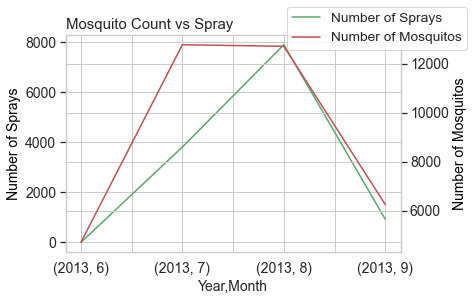

In [ ]:
#2013
spray2013 = list(spray[spray['year'] == '2013'].groupby(by=['year', 'month']).count()['date'].values)
spray2013.insert(0,0)
df = pd.DataFrame({"Year,Month": list(train[train['year'] == 2013].groupby(by=['year', 'month']).sum()['nummosquitos'].index),
                   "Number of Sprays": spray2013, 
                   "Number of Mosquitos": train[train['year'] == 2013].groupby(by=['year', 'month']).sum()['nummosquitos'].values})
ax = df.plot(x="Year,Month", y="Number of Sprays", legend=False, color="g")
ax2 = ax.twinx()
ax.set_ylabel('Number of Sprays', color='black', fontsize=14)
ax.set_xlabel('Year,Month', fontsize=14)
ax.tick_params(labelsize=14)
ax2.set_ylabel('Number of Mosquitos', color='black', fontsize=14)
ax2.tick_params(labelsize=14)
df.plot(x="Year,Month", y="Number of Mosquitos", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.title('Mosquito Count vs Spray',size=15,loc='left')
plt.show()

Interpretation: The two graphs above shows the relationship between the number of mosquitos and the number of sprays in the year 2011 and 2013 respectively. Both of the graphs illustrate that the spray should be used to reduce number of mosquitos.

In 2011, it is clear that there is a negative correlation between number of sprays and number of mosquitos in between the month of July and August, indicating that the spray is effective in terms of reducing mosquitos. 

In 2013, the number of mosquitos reaches a plateau in July after the spray was increasingly used. The number of mosquitos drops sharply in August at the same rate of the spray used. 

#### Predicting the area with high risk

We will be using the data to give us some ideas of the locations where there is a high risk of WNV presence for the most recent year in our test dataset.

In [ ]:
y_predict = gs_lr.predict(X_test)

In [ ]:
kaggle_predict = test_weather

In [ ]:
kaggle_predict['wnvpresent'] = y_predict

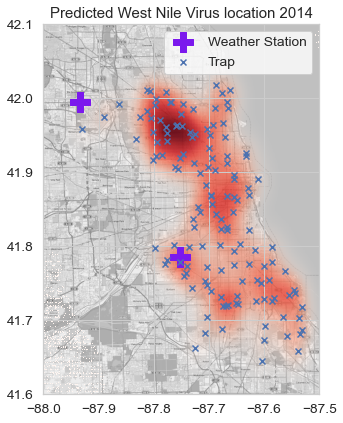

In [ ]:
# Virus

# Set style
alpha_wnv = plt.cm.Reds
alpha_wnv._init()
alpha_wnv._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_wnv.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(18,6*(len(all_species))))
virus_locs = kaggle_predict[['longitude','latitude', 'wnvpresent']]
virus_locs[virus_locs['wnvpresent'] == 1]
plt.subplot(len(all_species), 4, subplot)
plt.gca().set_title(f'Predicted West Nile Virus location 2014')
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)
plotHeatMap(virus_locs, alpha_wnv, plt)
plt.scatter(x = [-87.933, -87.752], y = [41.995, 41.786], marker='P', s=400, c = '#7b18ed', label = 'Weather Station')
plt.tight_layout()
locations = train[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', label = 'Trap')
plt.legend()
plt.show()

Interpretation: We use model to recommend the target areas for sprays. The dark red area is the area with high chance to found the mosquitos with WNV. The target areas are Albany Park, Irving Park, Portage Park, Avondale, Belmont Cragin, Logan Square and Hermosa which present the total area as 50.5 square kilometer and the estimated spray cost is $74,300.

#### Medical and Economic Costs
- Chicago’s GDP per capita: $61,170 [[Source]](https://apps.bea.gov/iTable/index_regional.cfm)

- Per day that would be $ 170
- Recovery Period from severe WNV could be anywhere from a several weeks to several months [[Source]](https://www.cdc.gov/westnile/symptoms/index.html#:~:text=Recovery%20from%20severe%20illness%20might,the%20central%20nervous%20system%20die.)
- We will assume a best case scenario of 3 weeks recovery period

- Per person total cost would be \\$ 3,570 economic cost + 25,000 medical cost = $ 28,570

- With the spraying/overtime cost of $900,000, only 30 severe WNV cases would be required to make the spraying cost effective in terms of the medical and economic impacts.


<img src="./images/cba2.PNG">

## Conclusion & Recommendations

#### Conclusion
With our goal to predict when and where different species of mosquitoes will test positive for WNV, we created several classification models to predict the presence of the virus. Among all the regression algorithms that we used, we found that Logistic Regression performed well compared than other model and the baseline. Given that it seems to be more generalised (lower variance) than other models, it scored the best on the testing data with the ROCAUC score of 0.756 and thus we will consider this model to be the most useful for this study.

Out of all the predictors for the model, we found that average temperature was the top predictor with the exponential coefficient at about 160. On the other hand, location was not a strong predictor in our best model, but weather and week of year were more important features.

Regarding cost benefit analysis, we found that the spray should be used to reduce number of mosquitos. Additionally, the spray cost for Chicago would be \\$900,000 and the total cost for the infected person would be \\$28,570. Hence, the spray cost will cover only 30 severe WNV cases. The target areas from the model have the total area at 50.5 square kilometer which requires \\$74,300 of spray cost. If the spray were to be used, Chicago Council should spray more in summer (August) because this month had more risk of WNV in human from the virus-carrying mosquitoes

#### Recommendations

- The sub-urban in Chicago has more risk from WNV due to the poor sanitation system in the older houses compared to new houses [[Source]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7241786/). Therefore, the Chicago council should give the sanitation maintenance to the old houses.
- We recommend to always spray to prevent the high medical cost and economic loss, and the spray help Chicago to prevent the unpredictability of WNV outbreaks in people


#### Next Steps

- Further improve the model by doing more feature engineering and try using other algorithms.
- Consider the human behaviour
- Examine the type and efficiency of the sprays
- Consider the income of people in each area
- Built model to predict outbreaks more reliability in humans